# Q-Learning for optimized trade execution

In this tutorial, we are going to look at how the tabular Q-Learning algorithm can be used to solve the optimized trade execution problem.

This problem is well known in finance and can be described as follows:

1. A trader wants to liquidate its position in a stock. However, the trader cannot sell all of its shares right away. The reason is that there might not be enough buyers willing to exchange shares with the trader at the market price. Hence, the trader would obtain a poor average price for its position.
 
2. The trader has to split its trading in time according to a schedule. For our problem, the trader will have a one full week of market (5 days) to trade. Each day, the trader must decide what quantity he will sell. At the end of the week, the trader must have sold all of his shares.

3. Every time the trader sells a block of shares, he will obtain a mean price lower than the market price. This can be described as a temporary impact that the trader has on the market due to limited liquidity. 

Finally, the trader also is risk averse. That means that he has a preference for selling shares earlier to avoid adverse price movement.

All the packages needed are included by default in Colab.

In [78]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as mgrid
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm

np.random.seed(123)

# Simulation environment

- Define the order duration as the time elapsed since the beginning of trading
- Define the volume to trade as the size of the the trader's initial position
- Define the inventory remaining as the number of blocks of shares that the trader still has to sell.



$$ Reward_{t} = A_{t}\times(Price_{t} - Impact_{temp}) - \lambda_{risk} \times (V_{t}-A_{t})^2$$

$$ Impact_{temp} = \lambda_{impact}\times A_{t}^{1.5}$$

$A_{t}$ is the action taken by the trader or the number of shares sold at time t. Later, we will split the actions in blocks of shares to keep the problem small. We will try to sell 10 blocks (or lot) of 100 shares. Finally, $V_{t}$ is the remaining volume to trade at time t. We will use the following state:

$$ S_{t} = (t, V_{t})$$

# Simple market simulation using arithmetic Brownian Motion

In [79]:
class Simulator():
    
    LOT_SIZE = 100 # number of shares in one block
    
    def __init__(self,
                 init_price,
                 volume_to_trade,
                 horizon,
                 bm_drift,
                 bm_variance,
                 risk_averse_coeff,
                 temp_impact_coeff):
        
        
        # Initial price
        self.init_price = init_price
        
        # Brownian motion drift and variance
        self.bm_drift = bm_drift
        self.bm_variance = bm_variance
        
        # Penalty coefficients
        self.risk_averse_coeff = risk_averse_coeff
        self.temp_impact_coeff = temp_impact_coeff
        
        
        self.volume_to_trade = volume_to_trade
        self.horizon = horizon
        
        
        self.reset()
        
        
    def reset(self):
        
        
        self.price_t = self.init_price
        self.order_duration = 0
        self.total_volume_traded = 0

        self.price_history = []
        self.volume_history = []

        initial_state = [self.order_duration, self._remaining_inventory()]
            
        return initial_state
    
        
    def risk_penalty(self):

        penalty = self.risk_averse_coeff * (self._remaining_inventory()*self.LOT_SIZE)**2
            
        return penalty
    
    def temporary_impact(self, volume_traded):
        
        impact = self.temp_impact_coeff * (volume_traded*self.LOT_SIZE)**(1.5)
        
        return impact
    
        
    def step(self, volume_traded, dt):
        
        # add to volume traded
        self.total_volume_traded += volume_traded
        
        # update price history
        self.price_history.append(self.price_t) 
        
        # price movement from brownian motion until decision
        self.price_t += dt*self.bm_drift + np.sqrt(self.bm_variance*dt)*np.random.normal()
        
        
        # mean price obtained for the volume traded        
        mean_price_obtained = self.price_t - self.temporary_impact(volume_traded)
        
        
        # proceedings of the sell, minus the risk penalty
        reward = volume_traded * self.LOT_SIZE * mean_price_obtained - self.risk_penalty()
        
        
        # advance time
        self.order_duration += dt
        
        # create new state list
        new_state = [self.order_duration, self._remaining_inventory()]
        
        # if we have reached the trading horizon or sold all the volume to trade, we are done
        done = False
        
        if (self.order_duration >= self.horizon) or \
           (self.total_volume_traded >= self.volume_to_trade):
            
            done=True
    
        
        return reward, new_state, done
    
    
    def action_space(self):
        # we cannot sell more than the remaining inventory.
        return self._remaining_inventory() + 1
        
        
    def _remaining_inventory(self):
        
        return self.volume_to_trade - self.total_volume_traded
    
    

# The Q-Learning algorithm

In [80]:
class QLearning():
    
    def __init__(self,
                 horizon,
                 volume_to_trade,
                 exploration_epsilon,
                 discount_gamma,
                 step_size,
                 init_value=0):
    
        # initialize each state-action pair value
        self.Q_values = np.ones((horizon+1, volume_to_trade+1, volume_to_trade+1))*init_value
        
        
        self.exploration_epsilon = exploration_epsilon
        self.discount_gamma = discount_gamma
        self.step_size = step_size # also called the learning rate
        
        
    def update_Q_values(self,
                        last_order_duration,
                        last_remaining_inventory,
                        action_taken,
                        reward_obtained,
                        next_order_duration,
                        next_remaining_inventory):
        
        # maximum at the next state
        next_state_max = np.max(self.Q_values[next_order_duration,
                                              next_remaining_inventory])
        
        # current state-action value
        current_state_action_value =  self.Q_values[last_order_duration,
                                                    last_remaining_inventory,
                                                    action_taken]
        
        # difference between current state and sampled transition's value
        target = reward_obtained + self.discount_gamma*next_state_max - current_state_action_value

        # update to the relevant state-action pair
        self.Q_values[last_order_duration,
                      last_remaining_inventory,
                      action_taken] =  current_state_action_value + self.step_size*target
        
        
    def final_update_Q_values(self,
                              last_order_duration,
                              last_remaining_inventory,
                              action_taken,
                              reward_obtained):

        
        current_state_action_value =  self.Q_values[last_order_duration,
                                                    last_remaining_inventory,
                                                    action_taken]

            
        # at the final state, we don't transition anymore and need only the reward, no next state's maximum
        target = reward_obtained - current_state_action_value
        
        
        self.Q_values[last_order_duration,
                      last_remaining_inventory,
                      action_taken] =  current_state_action_value + self.step_size*target
    
    
        
    def epsilon_greedy(self, order_duration, remaining_inventory, action_space):
        
        # if random uniform (0,1) is smaller than epsilon, pick a random action
        if np.random.rand()<self.exploration_epsilon:
            action = np.random.randint(action_space)
        else:
            action = self.greedy(order_duration, remaining_inventory, action_space)
            
        return action
    

    def greedy(self, order_duration, remaining_inventory, action_space):
        
        # pick the best action within the action space
        action = np.argmax(self.Q_values[order_duration][remaining_inventory][:action_space])
        
        return action
    
    def decay_epsilon(self, decay):
        
        self.exploration_epsilon *= decay
        
    def decay_step_size(self, decay):
        
        self.step_size *= decay
        
    

In [82]:

# This function will play a full episode using the greedy action every time
def eval_agent(agent, sim, dt):
    
    done = False

    order_duration, remaining_inventory = sim.reset()
    
    # will return the optimal trading schedule according to the current Q-values
    inventory_hist = [remaining_inventory]
    rewards_obtained = []

    while not done:

        action = agent.greedy(order_duration, remaining_inventory, sim.action_space())
        reward, new_state, done = sim.step(action, dt)

        order_duration, remaining_inventory = new_state

        inventory_hist.append(remaining_inventory)
        rewards_obtained.append(reward)

    return rewards_obtained, inventory_hist

In [83]:

init_price = 100. 
volume_to_trade = 10 # lots of 100 shares = 1000 shares
horizon = 5 # days

bm_drift = .00000 # zero drift for our example, but could be added
bm_variance = 0.5 # price variance of the browninan motion

risk_aversion = .005 # risk aversion penalty on the square of the number of shares remaining
temp_impact_coeff = 0.0005 # temporary impact coefficient

dt = 1 # timestep used for decision, 1 day


sim = Simulator(init_price,
                volume_to_trade,
                horizon,
                bm_drift,
                bm_variance,
                risk_aversion,
                temp_impact_coeff)


exploration_epsilon = .5
discount_gamma = 1. # we can use one since we are working in a finite horizon problem
step_size = 1. # initial learning rate
init_value = 0 # we initialize our Q-values to zero

agent = QLearning(horizon, volume_to_trade, exploration_epsilon, discount_gamma, step_size, init_value=init_value)

Text(0, 0.5, 'price')

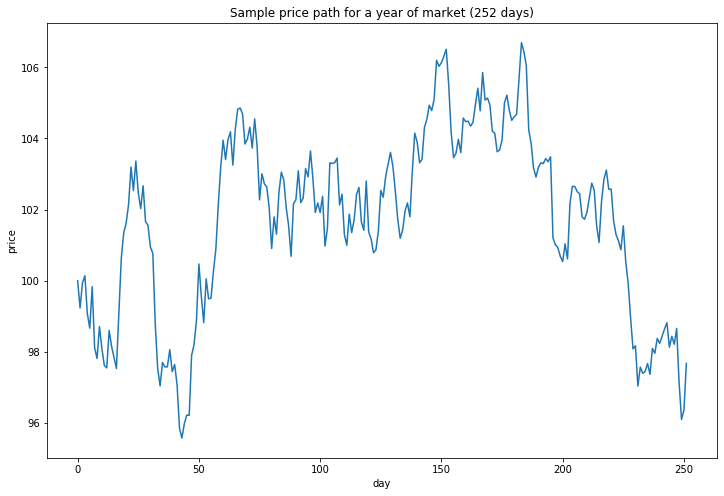

In [84]:
for i in range(252):
    sim.step(0, 1)

plt.figure(figsize=(12,8))
plt.title('Sample price path for a year of market (252 days)')
plt.plot(sim.price_history)
plt.xlabel('day')
plt.ylabel('price')

# Training loop

In [85]:


rolling_reward = -np.inf
rolling_rewards_hist = []


for episode in tqdm(range(50_000)):
    
    # Training the agent for one full episode
    
    order_duration, remaining_inventory = sim.reset() 

    done = False
    
    while not done:

        action_space = sim.action_space()
        action = agent.epsilon_greedy(order_duration, remaining_inventory, action_space)

        reward, new_state, done = sim.step(action, dt)


        if not done:

            agent.update_Q_values(order_duration, remaining_inventory, action, reward, new_state[0], new_state[1])
            order_duration, remaining_inventory = new_state

        else:

            agent.final_update_Q_values(order_duration, remaining_inventory, action, reward)
            agent.decay_step_size(0.99995)
            
    
    # Evaluate the agent's greedy policy for one episode
    
    rewards_obtained , _ = eval_agent(agent, sim, dt)
    
    if rolling_reward > -np.inf:
        rolling_reward = 0.99 * rolling_reward + .01 * np.sum(rewards_obtained)
    else:
        rolling_reward = np.sum(rewards_obtained)
    
    rolling_rewards_hist.append(rolling_reward)
    
    print(f'Episode {episode} - Rolling reward {rolling_reward} - Step size {agent.step_size}')
            
    

Episode 0 - Rolling reward 72119.23887582975 - Step size 0.99995
Episode 1 - Rolling reward 72123.20694086682 - Step size 0.9999000025
Episode 2 - Rolling reward 72219.7359464028 - Step size 0.999850007499875
Episode 3 - Rolling reward 72352.21900736945 - Step size 0.9998000149995
Episode 4 - Rolling reward 72456.37954502954 - Step size 0.99975002499875
Episode 5 - Rolling reward 72570.12182917968 - Step size 0.9997000374975
Episode 6 - Rolling reward 72707.42438140791 - Step size 0.9996500524956251
Episode 7 - Rolling reward 72818.7464593608 - Step size 0.9996000699930003
Episode 8 - Rolling reward 72926.25233557378 - Step size 0.9995500899895007
Episode 9 - Rolling reward 73035.85877691137 - Step size 0.9995001124850013
Episode 10 - Rolling reward 73130.84168182619 - Step size 0.999450137479377
Episode 11 - Rolling reward 73244.46386505048 - Step size 0.9994001649725031
Episode 12 - Rolling reward 73353.5002267636 - Step size 0.9993501949642545
Episode 13 - Rolling reward 73455.26816

Episode 235 - Rolling reward 92609.69376939215 - Step size 0.9882690554181227
Episode 236 - Rolling reward 92633.91912668718 - Step size 0.9882196419653518
Episode 237 - Rolling reward 92656.7641155901 - Step size 0.9881702309832536
Episode 238 - Rolling reward 92670.89364211459 - Step size 0.9881208224717045
Episode 239 - Rolling reward 92696.52258895323 - Step size 0.9880714164305809
Episode 240 - Rolling reward 92709.37683135027 - Step size 0.9880220128597594
Episode 241 - Rolling reward 92737.10154587225 - Step size 0.9879726117591164
Episode 242 - Rolling reward 92767.84650834191 - Step size 0.9879232131285285
Episode 243 - Rolling reward 92788.40732197574 - Step size 0.987873816967872
Episode 244 - Rolling reward 92810.89848623206 - Step size 0.9878244232770236
Episode 245 - Rolling reward 92832.96340369341 - Step size 0.9877750320558597
Episode 246 - Rolling reward 92844.65034529367 - Step size 0.9877256433042569
Episode 247 - Rolling reward 92855.09107765128 - Step size 0.98767

Episode 568 - Rolling reward 94620.0318610504 - Step size 0.9719501991528744
Episode 569 - Rolling reward 94619.4775808653 - Step size 0.9719016016429167
Episode 570 - Rolling reward 94614.9829274679 - Step size 0.9718530065628346
Episode 571 - Rolling reward 94601.0379542839 - Step size 0.9718044139125065
Episode 572 - Rolling reward 94600.16953965517 - Step size 0.9717558236918109
Episode 573 - Rolling reward 94605.87026130345 - Step size 0.9717072359006264
Episode 574 - Rolling reward 94601.02248660616 - Step size 0.9716586505388314
Episode 575 - Rolling reward 94611.12226972464 - Step size 0.9716100676063044
Episode 576 - Rolling reward 94609.25376054982 - Step size 0.9715614871029241
Episode 577 - Rolling reward 94610.9199873916 - Step size 0.971512909028569
Episode 578 - Rolling reward 94610.41169518064 - Step size 0.9714643333831176
Episode 579 - Rolling reward 94614.36334296818 - Step size 0.9714157601664484
Episode 580 - Rolling reward 94611.75099964139 - Step size 0.971367189

Episode 947 - Rolling reward 94728.17260971136 - Step size 0.9537047087697327
Episode 948 - Rolling reward 94720.0759510856 - Step size 0.9536570235342942
Episode 949 - Rolling reward 94716.71744643545 - Step size 0.9536093406831174
Episode 950 - Rolling reward 94721.93678377375 - Step size 0.9535616602160832
Episode 951 - Rolling reward 94723.95632508598 - Step size 0.9535139821330725
Episode 952 - Rolling reward 94713.5305363589 - Step size 0.9534663064339658
Episode 953 - Rolling reward 94704.90142411973 - Step size 0.953418633118644
Episode 954 - Rolling reward 94724.35143558677 - Step size 0.9533709621869881
Episode 955 - Rolling reward 94724.01754459494 - Step size 0.9533232936388788
Episode 956 - Rolling reward 94723.78379348722 - Step size 0.9532756274741968
Episode 957 - Rolling reward 94735.97700112297 - Step size 0.9532279636928231
Episode 958 - Rolling reward 94733.8287285766 - Step size 0.9531803022946385
Episode 959 - Rolling reward 94708.84341533852 - Step size 0.9531326

Episode 1223 - Rolling reward 94612.61965133934 - Step size 0.9406336547247034
Episode 1224 - Rolling reward 94619.2399909256 - Step size 0.9405866230419672
Episode 1225 - Rolling reward 94605.9750524394 - Step size 0.9405395937108151
Episode 1226 - Rolling reward 94609.09560286517 - Step size 0.9404925667311296
Episode 1227 - Rolling reward 94612.25618019211 - Step size 0.9404455421027931
Episode 1228 - Rolling reward 94617.3803862992 - Step size 0.9403985198256879
Episode 1229 - Rolling reward 94620.80259512406 - Step size 0.9403514998996966
Episode 1230 - Rolling reward 94620.08959277782 - Step size 0.9403044823247015
Episode 1231 - Rolling reward 94628.1039115291 - Step size 0.9402574671005853
Episode 1232 - Rolling reward 94627.98379401198 - Step size 0.9402104542272303
Episode 1233 - Rolling reward 94633.09770426103 - Step size 0.9401634437045189
Episode 1234 - Rolling reward 94639.93631051514 - Step size 0.9401164355323337
Episode 1235 - Rolling reward 94638.58324900993 - Step s

Episode 1610 - Rolling reward 94535.95411900985 - Step size 0.9226069140284073
Episode 1611 - Rolling reward 94541.06431454906 - Step size 0.9225607836827059
Episode 1612 - Rolling reward 94527.52424423449 - Step size 0.9225146556435218
Episode 1613 - Rolling reward 94528.87719968354 - Step size 0.9224685299107396
Episode 1614 - Rolling reward 94530.50846022628 - Step size 0.922422406484244
Episode 1615 - Rolling reward 94535.50552887288 - Step size 0.9223762853639198
Episode 1616 - Rolling reward 94527.30921101243 - Step size 0.9223301665496516
Episode 1617 - Rolling reward 94528.33704440903 - Step size 0.9222840500413241
Episode 1618 - Rolling reward 94523.91995348097 - Step size 0.922237935838822
Episode 1619 - Rolling reward 94530.201225488 - Step size 0.92219182394203
Episode 1620 - Rolling reward 94521.32394998928 - Step size 0.9221457143508329
Episode 1621 - Rolling reward 94527.05262206479 - Step size 0.9220996070651154
Episode 1622 - Rolling reward 94536.13925501199 - Step siz

Episode 1991 - Rolling reward 94713.8111316249 - Step size 0.905197171380932
Episode 1992 - Rolling reward 94704.75372593447 - Step size 0.905151911522363
Episode 1993 - Rolling reward 94703.49397089149 - Step size 0.9051066539267868
Episode 1994 - Rolling reward 94708.27142432098 - Step size 0.9050613985940905
Episode 1995 - Rolling reward 94703.88430920872 - Step size 0.9050161455241608
Episode 1996 - Rolling reward 94700.50256029447 - Step size 0.9049708947168845
Episode 1997 - Rolling reward 94694.04612454349 - Step size 0.9049256461721487
Episode 1998 - Rolling reward 94694.76082743284 - Step size 0.90488039988984
Episode 1999 - Rolling reward 94706.09938894544 - Step size 0.9048351558698455
Episode 2000 - Rolling reward 94702.77519703809 - Step size 0.904789914112052
Episode 2001 - Rolling reward 94696.15971146357 - Step size 0.9047446746163464
Episode 2002 - Rolling reward 94674.14665184332 - Step size 0.9046994373826156
Episode 2003 - Rolling reward 94678.97149468915 - Step siz

Episode 2381 - Rolling reward 94695.90818746 - Step size 0.8877163811532064
Episode 2382 - Rolling reward 94684.29762425921 - Step size 0.8876719953341488
Episode 2383 - Rolling reward 94697.59862566991 - Step size 0.8876276117343821
Episode 2384 - Rolling reward 94687.2670413422 - Step size 0.8875832303537954
Episode 2385 - Rolling reward 94697.0834425322 - Step size 0.8875388511922777
Episode 2386 - Rolling reward 94678.54983181716 - Step size 0.8874944742497181
Episode 2387 - Rolling reward 94690.28009707721 - Step size 0.8874500995260056
Episode 2388 - Rolling reward 94674.02176838179 - Step size 0.8874057270210294
Episode 2389 - Rolling reward 94665.97566562968 - Step size 0.8873613567346783
Episode 2390 - Rolling reward 94680.12772169363 - Step size 0.8873169886668416
Episode 2391 - Rolling reward 94677.509483718 - Step size 0.8872726228174083
Episode 2392 - Rolling reward 94671.36225213473 - Step size 0.8872282591862674
Episode 2393 - Rolling reward 94670.47581062329 - Step size

Episode 2786 - Rolling reward 94738.34717887946 - Step size 0.869920471251808
Episode 2787 - Rolling reward 94739.0899132928 - Step size 0.8698769752282455
Episode 2788 - Rolling reward 94734.59603977097 - Step size 0.869833481379484
Episode 2789 - Rolling reward 94719.82302437472 - Step size 0.8697899897054151
Episode 2790 - Rolling reward 94719.75214257132 - Step size 0.8697465002059298
Episode 2791 - Rolling reward 94715.43349457698 - Step size 0.8697030128809196
Episode 2792 - Rolling reward 94723.50222737894 - Step size 0.8696595277302756
Episode 2793 - Rolling reward 94714.73492016613 - Step size 0.8696160447538891
Episode 2794 - Rolling reward 94710.03141343873 - Step size 0.8695725639516514
Episode 2795 - Rolling reward 94706.93352995501 - Step size 0.8695290853234539
Episode 2796 - Rolling reward 94694.08604578042 - Step size 0.8694856088691877
Episode 2797 - Rolling reward 94688.7696908262 - Step size 0.8694421345887442
Episode 2798 - Rolling reward 94685.68543029948 - Step s

Episode 3125 - Rolling reward 94813.62028483955 - Step size 0.8552992189105996
Episode 3126 - Rolling reward 94805.16010034838 - Step size 0.855256453949654
Episode 3127 - Rolling reward 94803.34550611037 - Step size 0.8552136911269566
Episode 3128 - Rolling reward 94801.60481890793 - Step size 0.8551709304424002
Episode 3129 - Rolling reward 94820.28812694151 - Step size 0.8551281718958781
Episode 3130 - Rolling reward 94825.99642640806 - Step size 0.8550854154872833
Episode 3131 - Rolling reward 94816.89192679297 - Step size 0.855042661216509
Episode 3132 - Rolling reward 94809.83389728847 - Step size 0.8549999090834481
Episode 3133 - Rolling reward 94816.3905296708 - Step size 0.854957159087994
Episode 3134 - Rolling reward 94820.10553037508 - Step size 0.8549144112300395
Episode 3135 - Rolling reward 94806.53309716671 - Step size 0.854871665509478
Episode 3136 - Rolling reward 94797.13560601766 - Step size 0.8548289219262025
Episode 3137 - Rolling reward 94799.6130395807 - Step siz

Episode 3515 - Rolling reward 94826.36761157001 - Step size 0.8387820371291935
Episode 3516 - Rolling reward 94829.17064728733 - Step size 0.8387400980273371
Episode 3517 - Rolling reward 94822.56764946747 - Step size 0.8386981610224357
Episode 3518 - Rolling reward 94826.16376596253 - Step size 0.8386562261143845
Episode 3519 - Rolling reward 94826.83055263633 - Step size 0.8386142933030788
Episode 3520 - Rolling reward 94817.1258098022 - Step size 0.8385723625884136
Episode 3521 - Rolling reward 94803.84393725316 - Step size 0.8385304339702842
Episode 3522 - Rolling reward 94822.62447106274 - Step size 0.8384885074485856
Episode 3523 - Rolling reward 94828.91861588212 - Step size 0.8384465830232132
Episode 3524 - Rolling reward 94815.98557984727 - Step size 0.838404660694062
Episode 3525 - Rolling reward 94817.68436079836 - Step size 0.8383627404610273
Episode 3526 - Rolling reward 94809.95224737319 - Step size 0.8383208223240043
Episode 3527 - Rolling reward 94802.30127765161 - Step

Episode 3889 - Rolling reward 94646.15169451905 - Step size 0.8232421750982909
Episode 3890 - Rolling reward 94646.97659615437 - Step size 0.823201012989536
Episode 3891 - Rolling reward 94657.41424244907 - Step size 0.8231598529388865
Episode 3892 - Rolling reward 94658.7111014967 - Step size 0.8231186949462396
Episode 3893 - Rolling reward 94674.9620390701 - Step size 0.8230775390114923
Episode 3894 - Rolling reward 94673.65917245565 - Step size 0.8230363851345417
Episode 3895 - Rolling reward 94675.03175327159 - Step size 0.822995233315285
Episode 3896 - Rolling reward 94687.29653793301 - Step size 0.8229540835536192
Episode 3897 - Rolling reward 94683.00644973708 - Step size 0.8229129358494416
Episode 3898 - Rolling reward 94687.81248484021 - Step size 0.8228717902026491
Episode 3899 - Rolling reward 94699.57669824579 - Step size 0.822830646613139
Episode 3900 - Rolling reward 94712.34553716354 - Step size 0.8227895050808083
Episode 3901 - Rolling reward 94749.16866426101 - Step si

Episode 4142 - Rolling reward 94793.38416662747 - Step size 0.8128934962626766
Episode 4143 - Rolling reward 94798.73722730373 - Step size 0.8128528515878635
Episode 4144 - Rolling reward 94813.6311518182 - Step size 0.812812208945284
Episode 4145 - Rolling reward 94829.26526278182 - Step size 0.8127715683348368
Episode 4146 - Rolling reward 94829.63423589164 - Step size 0.81273092975642
Episode 4147 - Rolling reward 94827.88266358494 - Step size 0.8126902932099322
Episode 4148 - Rolling reward 94838.6148444558 - Step size 0.8126496586952717
Episode 4149 - Rolling reward 94836.97125697145 - Step size 0.812609026212337
Episode 4150 - Rolling reward 94825.72052303537 - Step size 0.8125683957610264
Episode 4151 - Rolling reward 94823.86734494053 - Step size 0.8125277673412383
Episode 4152 - Rolling reward 94818.93592866288 - Step size 0.8124871409528712
Episode 4153 - Rolling reward 94810.34216866078 - Step size 0.8124465165958236
Episode 4154 - Rolling reward 94818.55096222761 - Step siz

Episode 4413 - Rolling reward 94671.62459380506 - Step size 0.8019528064408425
Episode 4414 - Rolling reward 94637.81389382965 - Step size 0.8019127088005205
Episode 4415 - Rolling reward 94643.27472382455 - Step size 0.8018726131650804
Episode 4416 - Rolling reward 94631.22696011426 - Step size 0.8018325195344221
Episode 4417 - Rolling reward 94632.2672004902 - Step size 0.8017924279084454
Episode 4418 - Rolling reward 94630.43271137837 - Step size 0.80175233828705
Episode 4419 - Rolling reward 94649.34886927692 - Step size 0.8017122506701356
Episode 4420 - Rolling reward 94650.87634961768 - Step size 0.8016721650576021
Episode 4421 - Rolling reward 94657.26214832673 - Step size 0.8016320814493492
Episode 4422 - Rolling reward 94643.5645214353 - Step size 0.8015919998452767
Episode 4423 - Rolling reward 94634.54330281487 - Step size 0.8015519202452844
Episode 4424 - Rolling reward 94631.86994306682 - Step size 0.8015118426492722
Episode 4425 - Rolling reward 94619.18371818916 - Step s

Episode 4813 - Rolling reward 94764.1883633371 - Step size 0.786072683878402
Episode 4814 - Rolling reward 94753.67701779271 - Step size 0.7860333802442081
Episode 4815 - Rolling reward 94759.96510773571 - Step size 0.7859940785751959
Episode 4816 - Rolling reward 94761.27676127317 - Step size 0.7859547788712671
Episode 4817 - Rolling reward 94748.69935378688 - Step size 0.7859154811323236
Episode 4818 - Rolling reward 94752.76265177559 - Step size 0.785876185358267
Episode 4819 - Rolling reward 94758.16703111916 - Step size 0.785836891548999
Episode 4820 - Rolling reward 94750.02485655798 - Step size 0.7857975997044216
Episode 4821 - Rolling reward 94734.61648472634 - Step size 0.7857583098244364
Episode 4822 - Rolling reward 94730.4416915867 - Step size 0.7857190219089452
Episode 4823 - Rolling reward 94730.65717211096 - Step size 0.7856797359578497
Episode 4824 - Rolling reward 94735.03898557644 - Step size 0.7856404519710518
Episode 4825 - Rolling reward 94733.85754756989 - Step si

Episode 5219 - Rolling reward 94841.92163642509 - Step size 0.7702758933809539
Episode 5220 - Rolling reward 94846.96290652298 - Step size 0.7702373795862849
Episode 5221 - Rolling reward 94834.47580873755 - Step size 0.7701988677173056
Episode 5222 - Rolling reward 94829.19296696443 - Step size 0.7701603577739198
Episode 5223 - Rolling reward 94834.63644770296 - Step size 0.770121849756031
Episode 5224 - Rolling reward 94833.85644714603 - Step size 0.7700833436635433
Episode 5225 - Rolling reward 94853.69072938859 - Step size 0.77004483949636
Episode 5226 - Rolling reward 94837.55144822561 - Step size 0.7700063372543853
Episode 5227 - Rolling reward 94848.94625789685 - Step size 0.7699678369375226
Episode 5228 - Rolling reward 94850.49886707719 - Step size 0.7699293385456757
Episode 5229 - Rolling reward 94845.95437722799 - Step size 0.7698908420787484
Episode 5230 - Rolling reward 94840.84702974469 - Step size 0.7698523475366444
Episode 5231 - Rolling reward 94844.27749988367 - Step 

Episode 5577 - Rolling reward 94756.51711983395 - Step size 0.7566102853287512
Episode 5578 - Rolling reward 94748.02807973538 - Step size 0.7565724548144848
Episode 5579 - Rolling reward 94744.67968726397 - Step size 0.756534626191744
Episode 5580 - Rolling reward 94761.96757573115 - Step size 0.7564967994604345
Episode 5581 - Rolling reward 94752.9874862601 - Step size 0.7564589746204614
Episode 5582 - Rolling reward 94765.17944033189 - Step size 0.7564211516717304
Episode 5583 - Rolling reward 94773.9830747134 - Step size 0.7563833306141469
Episode 5584 - Rolling reward 94775.13593388454 - Step size 0.7563455114476162
Episode 5585 - Rolling reward 94767.94770713977 - Step size 0.7563076941720438
Episode 5586 - Rolling reward 94772.36703141949 - Step size 0.7562698787873352
Episode 5587 - Rolling reward 94775.7439449643 - Step size 0.7562320652933958
Episode 5588 - Rolling reward 94765.7540581982 - Step size 0.7561942536901312
Episode 5589 - Rolling reward 94765.9377180789 - Step siz

Episode 5862 - Rolling reward 94738.51622212821 - Step size 0.7459047790165587
Episode 5863 - Rolling reward 94734.12366649219 - Step size 0.7458674837776079
Episode 5864 - Rolling reward 94720.20102475128 - Step size 0.745830190403419
Episode 5865 - Rolling reward 94707.68361846876 - Step size 0.7457928988938989
Episode 5866 - Rolling reward 94706.07736515133 - Step size 0.7457556092489542
Episode 5867 - Rolling reward 94704.57245907965 - Step size 0.7457183214684918
Episode 5868 - Rolling reward 94708.06512620207 - Step size 0.7456810355524184
Episode 5869 - Rolling reward 94696.66769575315 - Step size 0.7456437515006408
Episode 5870 - Rolling reward 94695.19945046693 - Step size 0.7456064693130657
Episode 5871 - Rolling reward 94689.21810333426 - Step size 0.7455691889896001
Episode 5872 - Rolling reward 94687.59604371474 - Step size 0.7455319105301507
Episode 5873 - Rolling reward 94701.53290748798 - Step size 0.7454946339346241
Episode 5874 - Rolling reward 94692.79310663704 - Ste

Episode 6211 - Rolling reward 94858.23430445894 - Step size 0.733001328077483
Episode 6212 - Rolling reward 94860.47353029279 - Step size 0.7329646780110791
Episode 6213 - Rolling reward 94844.37186041939 - Step size 0.7329280297771785
Episode 6214 - Rolling reward 94845.98397706053 - Step size 0.7328913833756897
Episode 6215 - Rolling reward 94834.67658323116 - Step size 0.732854738806521
Episode 6216 - Rolling reward 94825.78121220107 - Step size 0.7328180960695806
Episode 6217 - Rolling reward 94833.17902153202 - Step size 0.7327814551647771
Episode 6218 - Rolling reward 94848.11901609792 - Step size 0.7327448160920189
Episode 6219 - Rolling reward 94846.2800250693 - Step size 0.7327081788512143
Episode 6220 - Rolling reward 94852.66840505232 - Step size 0.7326715434422717
Episode 6221 - Rolling reward 94861.89565919386 - Step size 0.7326349098650996
Episode 6222 - Rolling reward 94862.8169957375 - Step size 0.7325982781196063
Episode 6223 - Rolling reward 94861.20642257994 - Step s

Episode 6603 - Rolling reward 94793.40858240308 - Step size 0.7187740293608841
Episode 6604 - Rolling reward 94782.38889032337 - Step size 0.7187380906594161
Episode 6605 - Rolling reward 94778.66973366308 - Step size 0.7187021537548831
Episode 6606 - Rolling reward 94772.65994997915 - Step size 0.7186662186471954
Episode 6607 - Rolling reward 94780.4662170174 - Step size 0.718630285336263
Episode 6608 - Rolling reward 94784.72557372371 - Step size 0.7185943538219962
Episode 6609 - Rolling reward 94794.16420863249 - Step size 0.7185584241043051
Episode 6610 - Rolling reward 94795.29009151725 - Step size 0.7185224961830999
Episode 6611 - Rolling reward 94806.91186188906 - Step size 0.7184865700582908
Episode 6612 - Rolling reward 94805.7167286186 - Step size 0.7184506457297879
Episode 6613 - Rolling reward 94803.70930873186 - Step size 0.7184147231975014
Episode 6614 - Rolling reward 94799.29647259404 - Step size 0.7183788024613416
Episode 6615 - Rolling reward 94792.08619518252 - Step 

Episode 7004 - Rolling reward 94798.18985352878 - Step size 0.7045057706546761
Episode 7005 - Rolling reward 94801.68358641175 - Step size 0.7044705453661434
Episode 7006 - Rolling reward 94795.90678644914 - Step size 0.7044353218388751
Episode 7007 - Rolling reward 94807.7295257476 - Step size 0.7044001000727832
Episode 7008 - Rolling reward 94805.28347532189 - Step size 0.7043648800677795
Episode 7009 - Rolling reward 94811.74124842354 - Step size 0.7043296618237761
Episode 7010 - Rolling reward 94808.46626861033 - Step size 0.7042944453406849
Episode 7011 - Rolling reward 94808.41267624166 - Step size 0.7042592306184178
Episode 7012 - Rolling reward 94806.43564464986 - Step size 0.7042240176568869
Episode 7013 - Rolling reward 94811.88793881766 - Step size 0.7041888064560041
Episode 7014 - Rolling reward 94816.46253662433 - Step size 0.7041535970156814
Episode 7015 - Rolling reward 94818.74049683797 - Step size 0.7041183893358306
Episode 7016 - Rolling reward 94812.66365613023 - Ste

Episode 7372 - Rolling reward 94725.82157228788 - Step size 0.6916610769354692
Episode 7373 - Rolling reward 94720.21478737806 - Step size 0.6916264938816225
Episode 7374 - Rolling reward 94721.70447595918 - Step size 0.6915919125569284
Episode 7375 - Rolling reward 94715.79503987098 - Step size 0.6915573329613006
Episode 7376 - Rolling reward 94720.91300791712 - Step size 0.6915227550946526
Episode 7377 - Rolling reward 94722.31679823724 - Step size 0.6914881789568978
Episode 7378 - Rolling reward 94711.9313696695 - Step size 0.69145360454795
Episode 7379 - Rolling reward 94704.51961623998 - Step size 0.6914190318677226
Episode 7380 - Rolling reward 94705.14236651655 - Step size 0.6913844609161292
Episode 7381 - Rolling reward 94718.61823453914 - Step size 0.6913498916930834
Episode 7382 - Rolling reward 94696.30145544295 - Step size 0.6913153241984987
Episode 7383 - Rolling reward 94694.26474860839 - Step size 0.6912807584322888
Episode 7384 - Rolling reward 94688.195253826 - Step si

Episode 7690 - Rolling reward 94789.69600595706 - Step size 0.6807503630834435
Episode 7691 - Rolling reward 94807.69946037227 - Step size 0.6807163255652894
Episode 7692 - Rolling reward 94830.20022718271 - Step size 0.6806822897490111
Episode 7693 - Rolling reward 94834.01027178163 - Step size 0.6806482556345237
Episode 7694 - Rolling reward 94828.35351455929 - Step size 0.6806142232217419
Episode 7695 - Rolling reward 94835.88480803234 - Step size 0.6805801925105809
Episode 7696 - Rolling reward 94832.08717982305 - Step size 0.6805461635009553
Episode 7697 - Rolling reward 94824.7245808086 - Step size 0.6805121361927803
Episode 7698 - Rolling reward 94820.90919916058 - Step size 0.6804781105859706
Episode 7699 - Rolling reward 94828.2680930775 - Step size 0.6804440866804413
Episode 7700 - Rolling reward 94811.04478192193 - Step size 0.6804100644761073
Episode 7701 - Rolling reward 94805.43831067481 - Step size 0.6803760439728835
Episode 7702 - Rolling reward 94798.84469030968 - Step

Episode 7953 - Rolling reward 94798.03182870058 - Step size 0.671856876305273
Episode 7954 - Rolling reward 94799.99947688889 - Step size 0.6718232834614578
Episode 7955 - Rolling reward 94791.05650876401 - Step size 0.6717896922972847
Episode 7956 - Rolling reward 94784.84806711625 - Step size 0.6717561028126698
Episode 7957 - Rolling reward 94774.15926272435 - Step size 0.6717225150075292
Episode 7958 - Rolling reward 94772.56879992827 - Step size 0.6716889288817789
Episode 7959 - Rolling reward 94767.5262717887 - Step size 0.6716553444353348
Episode 7960 - Rolling reward 94774.46900882109 - Step size 0.671621761668113
Episode 7961 - Rolling reward 94769.08553434114 - Step size 0.6715881805800297
Episode 7962 - Rolling reward 94779.17588997733 - Step size 0.6715546011710006
Episode 7963 - Rolling reward 94771.31757137738 - Step size 0.6715210234409421
Episode 7964 - Rolling reward 94770.44676961581 - Step size 0.6714874473897701
Episode 7965 - Rolling reward 94760.92411074109 - Step 

Episode 8359 - Rolling reward 94844.14257286723 - Step size 0.6583553483461777
Episode 8360 - Rolling reward 94840.66224274003 - Step size 0.6583224305787604
Episode 8361 - Rolling reward 94837.11427611308 - Step size 0.6582895144572315
Episode 8362 - Rolling reward 94835.75476256295 - Step size 0.6582565999815086
Episode 8363 - Rolling reward 94832.40147049954 - Step size 0.6582236871515096
Episode 8364 - Rolling reward 94847.67649871131 - Step size 0.658190775967152
Episode 8365 - Rolling reward 94851.50469609413 - Step size 0.6581578664283537
Episode 8366 - Rolling reward 94847.76865716939 - Step size 0.6581249585350323
Episode 8367 - Rolling reward 94853.28848258185 - Step size 0.6580920522871055
Episode 8368 - Rolling reward 94845.92048081117 - Step size 0.6580591476844911
Episode 8369 - Rolling reward 94856.21925492716 - Step size 0.6580262447271069
Episode 8370 - Rolling reward 94864.36775722535 - Step size 0.6579933434148706
Episode 8371 - Rolling reward 94870.92719086446 - Ste

Episode 8744 - Rolling reward 94784.05651720667 - Step size 0.6458028990308725
Episode 8745 - Rolling reward 94788.34561131963 - Step size 0.645770608885921
Episode 8746 - Rolling reward 94790.35577827616 - Step size 0.6457383203554766
Episode 8747 - Rolling reward 94802.58041260134 - Step size 0.6457060334394589
Episode 8748 - Rolling reward 94793.5233044528 - Step size 0.6456737481377869
Episode 8749 - Rolling reward 94798.67326739608 - Step size 0.64564146445038
Episode 8750 - Rolling reward 94796.07935376074 - Step size 0.6456091823771575
Episode 8751 - Rolling reward 94786.89135821303 - Step size 0.6455769019180386
Episode 8752 - Rolling reward 94775.97393534653 - Step size 0.6455446230729427
Episode 8753 - Rolling reward 94768.47262957793 - Step size 0.6455123458417891
Episode 8754 - Rolling reward 94757.99351966611 - Step size 0.6454800702244969
Episode 8755 - Rolling reward 94764.9443952139 - Step size 0.6454477962209857
Episode 8756 - Rolling reward 94767.53900366479 - Step si

Episode 9040 - Rolling reward 94786.68327270195 - Step size 0.6363151613749872
Episode 9041 - Rolling reward 94793.43894545367 - Step size 0.6362833456169185
Episode 9042 - Rolling reward 94798.44202866592 - Step size 0.6362515314496376
Episode 9043 - Rolling reward 94796.84298429688 - Step size 0.6362197188730652
Episode 9044 - Rolling reward 94807.18481589264 - Step size 0.6361879078871215
Episode 9045 - Rolling reward 94792.13543682442 - Step size 0.6361560984917272
Episode 9046 - Rolling reward 94793.39484877855 - Step size 0.6361242906868025
Episode 9047 - Rolling reward 94800.75251238249 - Step size 0.6360924844722682
Episode 9048 - Rolling reward 94820.14413735882 - Step size 0.6360606798480446
Episode 9049 - Rolling reward 94829.31140649543 - Step size 0.6360288768140522
Episode 9050 - Rolling reward 94837.87075849158 - Step size 0.6359970753702114
Episode 9051 - Rolling reward 94823.36038241463 - Step size 0.6359652755164429
Episode 9052 - Rolling reward 94821.78912782186 - St

Episode 9236 - Rolling reward 94758.86618642145 - Step size 0.6301095746938311
Episode 9237 - Rolling reward 94745.24396098555 - Step size 0.6300780692150965
Episode 9238 - Rolling reward 94742.11923243546 - Step size 0.6300465653116357
Episode 9239 - Rolling reward 94743.2747660369 - Step size 0.6300150629833702
Episode 9240 - Rolling reward 94758.51237314088 - Step size 0.629983562230221
Episode 9241 - Rolling reward 94756.46415090834 - Step size 0.6299520630521095
Episode 9242 - Rolling reward 94749.8137763359 - Step size 0.6299205654489569
Episode 9243 - Rolling reward 94756.9551650049 - Step size 0.6298890694206845
Episode 9244 - Rolling reward 94749.02220045653 - Step size 0.6298575749672134
Episode 9245 - Rolling reward 94754.11156788355 - Step size 0.629826082088465
Episode 9246 - Rolling reward 94754.32192601453 - Step size 0.6297945907843606
Episode 9247 - Rolling reward 94764.08055060683 - Step size 0.6297631010548214
Episode 9248 - Rolling reward 94758.63980903277 - Step si

Episode 9604 - Rolling reward 94756.59832954055 - Step size 0.6186212876795731
Episode 9605 - Rolling reward 94753.79375817228 - Step size 0.6185903566151891
Episode 9606 - Rolling reward 94753.8431161182 - Step size 0.6185594270973583
Episode 9607 - Rolling reward 94764.09255478914 - Step size 0.6185284991260035
Episode 9608 - Rolling reward 94779.9075987912 - Step size 0.6184975727010472
Episode 9609 - Rolling reward 94785.33645359367 - Step size 0.6184666478224121
Episode 9610 - Rolling reward 94804.31572123268 - Step size 0.618435724490021
Episode 9611 - Rolling reward 94790.22923137041 - Step size 0.6184048027037965
Episode 9612 - Rolling reward 94799.91305579526 - Step size 0.6183738824636613
Episode 9613 - Rolling reward 94796.43008462134 - Step size 0.6183429637695381
Episode 9614 - Rolling reward 94800.24279846475 - Step size 0.6183120466213496
Episode 9615 - Rolling reward 94797.38199476141 - Step size 0.6182811310190186
Episode 9616 - Rolling reward 94799.97268796271 - Step 

Episode 9985 - Rolling reward 94739.48743899148 - Step size 0.606947803283357
Episode 9986 - Rolling reward 94746.32992653595 - Step size 0.6069174558931928
Episode 9987 - Rolling reward 94750.19868801453 - Step size 0.6068871100203982
Episode 9988 - Rolling reward 94759.65249658618 - Step size 0.6068567656648972
Episode 9989 - Rolling reward 94749.46236383397 - Step size 0.6068264228266139
Episode 9990 - Rolling reward 94762.4726753882 - Step size 0.6067960815054726
Episode 9991 - Rolling reward 94762.91884467646 - Step size 0.6067657417013973
Episode 9992 - Rolling reward 94753.99045506684 - Step size 0.6067354034143122
Episode 9993 - Rolling reward 94758.626511063 - Step size 0.6067050666441415
Episode 9994 - Rolling reward 94750.3856723017 - Step size 0.6066747313908093
Episode 9995 - Rolling reward 94759.97269755848 - Step size 0.6066443976542397
Episode 9996 - Rolling reward 94757.55140007254 - Step size 0.606614065434357
Episode 9997 - Rolling reward 94764.59491822566 - Step siz

Episode 10369 - Rolling reward 94819.64200251004 - Step size 0.5954052797140995
Episode 10370 - Rolling reward 94815.22736222816 - Step size 0.5953755094501139
Episode 10371 - Rolling reward 94819.17083015371 - Step size 0.5953457406746414
Episode 10372 - Rolling reward 94831.41425124294 - Step size 0.5953159733876077
Episode 10373 - Rolling reward 94841.52567228851 - Step size 0.5952862075889382
Episode 10374 - Rolling reward 94833.12827467766 - Step size 0.5952564432785588
Episode 10375 - Rolling reward 94829.12823671431 - Step size 0.5952266804563948
Episode 10376 - Rolling reward 94832.89211861127 - Step size 0.595196919122372
Episode 10377 - Rolling reward 94823.1925201135 - Step size 0.595167159276416
Episode 10378 - Rolling reward 94831.2584937829 - Step size 0.5951374009184521
Episode 10379 - Rolling reward 94823.36135518075 - Step size 0.5951076440484062
Episode 10380 - Rolling reward 94820.56563830035 - Step size 0.5950778886662038
Episode 10381 - Rolling reward 94810.6595931

Episode 10741 - Rolling reward 94757.11169868126 - Step size 0.5844328273467256
Episode 10742 - Rolling reward 94755.00968865979 - Step size 0.5844036057053583
Episode 10743 - Rolling reward 94760.81348736821 - Step size 0.584374385525073
Episode 10744 - Rolling reward 94775.72133340142 - Step size 0.5843451668057967
Episode 10745 - Rolling reward 94787.16921877507 - Step size 0.5843159495474565
Episode 10746 - Rolling reward 94785.43884273639 - Step size 0.5842867337499791
Episode 10747 - Rolling reward 94786.93344432862 - Step size 0.5842575194132916
Episode 10748 - Rolling reward 94788.39522388804 - Step size 0.5842283065373209
Episode 10749 - Rolling reward 94781.9675834706 - Step size 0.5841990951219941
Episode 10750 - Rolling reward 94787.10066176963 - Step size 0.584169885167238
Episode 10751 - Rolling reward 94797.640991998 - Step size 0.5841406766729796
Episode 10752 - Rolling reward 94804.49495572591 - Step size 0.584111469639146
Episode 10753 - Rolling reward 94815.587804300

Episode 11093 - Rolling reward 94844.7003671298 - Step size 0.5742365451647004
Episode 11094 - Rolling reward 94845.06983266582 - Step size 0.5742078333374421
Episode 11095 - Rolling reward 94851.28789232236 - Step size 0.5741791229457752
Episode 11096 - Rolling reward 94852.34340473518 - Step size 0.574150413989628
Episode 11097 - Rolling reward 94842.45491975936 - Step size 0.5741217064689285
Episode 11098 - Rolling reward 94840.66719311723 - Step size 0.574093000383605
Episode 11099 - Rolling reward 94833.3027278944 - Step size 0.5740642957335859
Episode 11100 - Rolling reward 94845.76686079461 - Step size 0.5740355925187992
Episode 11101 - Rolling reward 94837.31365704886 - Step size 0.5740068907391733
Episode 11102 - Rolling reward 94836.48664754012 - Step size 0.5739781903946364
Episode 11103 - Rolling reward 94838.99309898146 - Step size 0.5739494914851166
Episode 11104 - Rolling reward 94843.72510785826 - Step size 0.5739207940105424
Episode 11105 - Rolling reward 94851.2153380

Episode 11459 - Rolling reward 94851.79353845761 - Step size 0.5638233276087289
Episode 11460 - Rolling reward 94858.9465671904 - Step size 0.5637951364423485
Episode 11461 - Rolling reward 94852.82071859362 - Step size 0.5637669466855264
Episode 11462 - Rolling reward 94849.84155253641 - Step size 0.5637387583381921
Episode 11463 - Rolling reward 94858.34881382722 - Step size 0.5637105714002751
Episode 11464 - Rolling reward 94860.69029662183 - Step size 0.5636823858717052
Episode 11465 - Rolling reward 94862.74007954902 - Step size 0.5636542017524115
Episode 11466 - Rolling reward 94853.12851083056 - Step size 0.5636260190423239
Episode 11467 - Rolling reward 94846.46097006921 - Step size 0.5635978377413717
Episode 11468 - Rolling reward 94832.44946563823 - Step size 0.5635696578494847
Episode 11469 - Rolling reward 94840.45259368114 - Step size 0.5635414793665922
Episode 11470 - Rolling reward 94846.43216985142 - Step size 0.5635133022926239
Episode 11471 - Rolling reward 94838.7523

Episode 11870 - Rolling reward 94679.64288349956 - Step size 0.5523547151113055
Episode 11871 - Rolling reward 94697.39736707606 - Step size 0.55232709737555
Episode 11872 - Rolling reward 94696.24011629805 - Step size 0.5522994810206812
Episode 11873 - Rolling reward 94687.62424959852 - Step size 0.5522718660466301
Episode 11874 - Rolling reward 94698.30757316378 - Step size 0.5522442524533279
Episode 11875 - Rolling reward 94693.04338798471 - Step size 0.5522166402407052
Episode 11876 - Rolling reward 94683.36238397287 - Step size 0.5521890294086931
Episode 11877 - Rolling reward 94681.54807726716 - Step size 0.5521614199572227
Episode 11878 - Rolling reward 94674.50896291032 - Step size 0.5521338118862248
Episode 11879 - Rolling reward 94683.09015108383 - Step size 0.5521062051956305
Episode 11880 - Rolling reward 94667.51982876363 - Step size 0.5520785998853707
Episode 11881 - Rolling reward 94675.86319707651 - Step size 0.5520509959553764
Episode 11882 - Rolling reward 94668.68192

Episode 12179 - Rolling reward 94754.27583501012 - Step size 0.5438862107029895
Episode 12180 - Rolling reward 94766.39816661143 - Step size 0.5438590163924544
Episode 12181 - Rolling reward 94774.20233833924 - Step size 0.5438318234416347
Episode 12182 - Rolling reward 94787.4235672635 - Step size 0.5438046318504627
Episode 12183 - Rolling reward 94804.23317313344 - Step size 0.5437774416188702
Episode 12184 - Rolling reward 94817.94322910826 - Step size 0.5437502527467892
Episode 12185 - Rolling reward 94821.32167764711 - Step size 0.5437230652341519
Episode 12186 - Rolling reward 94819.85790615597 - Step size 0.5436958790808902
Episode 12187 - Rolling reward 94811.59561549702 - Step size 0.5436686942869362
Episode 12188 - Rolling reward 94814.43358278277 - Step size 0.5436415108522219
Episode 12189 - Rolling reward 94815.00379580453 - Step size 0.5436143287766793
Episode 12190 - Rolling reward 94807.4959456723 - Step size 0.5435871480602404
Episode 12191 - Rolling reward 94785.51008

Episode 12382 - Rolling reward 94905.29035269351 - Step size 0.5383935507526879
Episode 12383 - Rolling reward 94902.71198261307 - Step size 0.5383666310751503
Episode 12384 - Rolling reward 94906.96226405936 - Step size 0.5383397127435965
Episode 12385 - Rolling reward 94910.09880093439 - Step size 0.5383127957579593
Episode 12386 - Rolling reward 94903.47987901568 - Step size 0.5382858801181715
Episode 12387 - Rolling reward 94910.25259903171 - Step size 0.5382589658241655
Episode 12388 - Rolling reward 94909.52215813017 - Step size 0.5382320528758744
Episode 12389 - Rolling reward 94893.22397221415 - Step size 0.5382051412732306
Episode 12390 - Rolling reward 94907.30189450162 - Step size 0.5381782310161669
Episode 12391 - Rolling reward 94906.28367221412 - Step size 0.5381513221046161
Episode 12392 - Rolling reward 94911.5689524072 - Step size 0.5381244145385109
Episode 12393 - Rolling reward 94918.8895890699 - Step size 0.538097508317784
Episode 12394 - Rolling reward 94904.684773

Episode 12758 - Rolling reward 94849.34520185927 - Step size 0.5283660551168512
Episode 12759 - Rolling reward 94854.88495826868 - Step size 0.5283396368140953
Episode 12760 - Rolling reward 94851.86050167154 - Step size 0.5283132198322547
Episode 12761 - Rolling reward 94855.94661243049 - Step size 0.5282868041712631
Episode 12762 - Rolling reward 94856.83961358068 - Step size 0.5282603898310545
Episode 12763 - Rolling reward 94853.08281391348 - Step size 0.5282339768115629
Episode 12764 - Rolling reward 94856.65954466218 - Step size 0.5282075651127224
Episode 12765 - Rolling reward 94859.70170506711 - Step size 0.5281811547344667
Episode 12766 - Rolling reward 94865.13117247149 - Step size 0.5281547456767299
Episode 12767 - Rolling reward 94869.5693580063 - Step size 0.5281283379394461
Episode 12768 - Rolling reward 94866.76591849665 - Step size 0.5281019315225491
Episode 12769 - Rolling reward 94877.15067404632 - Step size 0.528075526425973
Episode 12770 - Rolling reward 94879.84436

Episode 13097 - Rolling reward 94818.09482030779 - Step size 0.5194855037610747
Episode 13098 - Rolling reward 94819.0678276369 - Step size 0.5194595294858867
Episode 13099 - Rolling reward 94804.76910616925 - Step size 0.5194335565094124
Episode 13100 - Rolling reward 94795.90622154856 - Step size 0.5194075848315869
Episode 13101 - Rolling reward 94809.80366059857 - Step size 0.5193816144523453
Episode 13102 - Rolling reward 94801.21520136116 - Step size 0.5193556453716227
Episode 13103 - Rolling reward 94790.66959949672 - Step size 0.5193296775893541
Episode 13104 - Rolling reward 94796.60145338504 - Step size 0.5193037111054747
Episode 13105 - Rolling reward 94804.11429365916 - Step size 0.5192777459199194
Episode 13106 - Rolling reward 94806.3843679409 - Step size 0.5192517820326233
Episode 13107 - Rolling reward 94821.73989170563 - Step size 0.5192258194435218
Episode 13108 - Rolling reward 94819.85178238596 - Step size 0.5191998581525495
Episode 13109 - Rolling reward 94809.97043

Episode 13428 - Rolling reward 94908.0981526766 - Step size 0.510958560586475
Episode 13429 - Rolling reward 94901.10773460846 - Step size 0.5109330126584457
Episode 13430 - Rolling reward 94916.91474060145 - Step size 0.5109074660078128
Episode 13431 - Rolling reward 94916.13638979806 - Step size 0.5108819206345124
Episode 13432 - Rolling reward 94924.4086321068 - Step size 0.5108563765384807
Episode 13433 - Rolling reward 94924.84639080401 - Step size 0.5108308337196538
Episode 13434 - Rolling reward 94920.61745401699 - Step size 0.5108052921779678
Episode 13435 - Rolling reward 94916.0955458151 - Step size 0.5107797519133589
Episode 13436 - Rolling reward 94919.73397488061 - Step size 0.5107542129257632
Episode 13437 - Rolling reward 94919.28907226284 - Step size 0.5107286752151169
Episode 13438 - Rolling reward 94899.24757745773 - Step size 0.5107031387813561
Episode 13439 - Rolling reward 94881.41827012373 - Step size 0.510677603624417
Episode 13440 - Rolling reward 94904.55524025

Episode 13688 - Rolling reward 94867.02349972003 - Step size 0.5043589248855708
Episode 13689 - Rolling reward 94859.52761496951 - Step size 0.5043337069393264
Episode 13690 - Rolling reward 94867.29901222477 - Step size 0.5043084902539795
Episode 13691 - Rolling reward 94864.03471692804 - Step size 0.5042832748294668
Episode 13692 - Rolling reward 94866.95706390914 - Step size 0.5042580606657253
Episode 13693 - Rolling reward 94881.14755740139 - Step size 0.5042328477626921
Episode 13694 - Rolling reward 94872.09540937161 - Step size 0.504207636120304
Episode 13695 - Rolling reward 94871.44501518045 - Step size 0.5041824257384979
Episode 13696 - Rolling reward 94884.80148766829 - Step size 0.504157216617211
Episode 13697 - Rolling reward 94881.72953317295 - Step size 0.5041320087563802
Episode 13698 - Rolling reward 94893.06537545747 - Step size 0.5041068021559424
Episode 13699 - Rolling reward 94889.51653849872 - Step size 0.5040815968158346
Episode 13700 - Rolling reward 94889.04248

Episode 13846 - Rolling reward 94870.22807356053 - Step size 0.5003900877058336
Episode 13847 - Rolling reward 94887.09306323207 - Step size 0.5003650682014483
Episode 13848 - Rolling reward 94870.30388046094 - Step size 0.5003400499480383
Episode 13849 - Rolling reward 94878.70304271665 - Step size 0.5003150329455409
Episode 13850 - Rolling reward 94878.91428317533 - Step size 0.5002900171938937
Episode 13851 - Rolling reward 94881.85119490932 - Step size 0.500265002693034
Episode 13852 - Rolling reward 94895.89532040211 - Step size 0.5002399894428994
Episode 13853 - Rolling reward 94898.83572212917 - Step size 0.5002149774434272
Episode 13854 - Rolling reward 94885.06674344729 - Step size 0.5001899666945551
Episode 13855 - Rolling reward 94897.58262612429 - Step size 0.5001649571962203
Episode 13856 - Rolling reward 94912.96011196167 - Step size 0.5001399489483606
Episode 13857 - Rolling reward 94914.80364155686 - Step size 0.5001149419509131
Episode 13858 - Rolling reward 94912.4351

Episode 14068 - Rolling reward 94760.74161140567 - Step size 0.49486633319129264
Episode 14069 - Rolling reward 94756.35840759585 - Step size 0.49484158987463306
Episode 14070 - Rolling reward 94744.8951169821 - Step size 0.49481684779513935
Episode 14071 - Rolling reward 94736.21414280975 - Step size 0.4947921069527496
Episode 14072 - Rolling reward 94739.67707667762 - Step size 0.49476736734740195
Episode 14073 - Rolling reward 94734.06162571193 - Step size 0.4947426289790346
Episode 14074 - Rolling reward 94742.19445101173 - Step size 0.49471789184758563
Episode 14075 - Rolling reward 94761.18360909093 - Step size 0.49469315595299324
Episode 14076 - Rolling reward 94779.0054472047 - Step size 0.4946684212951956
Episode 14077 - Rolling reward 94776.8311466121 - Step size 0.4946436878741309
Episode 14078 - Rolling reward 94780.35763416112 - Step size 0.4946189556897372
Episode 14079 - Rolling reward 94771.28891144885 - Step size 0.4945942247419527
Episode 14080 - Rolling reward 94764.

Episode 14316 - Rolling reward 94693.6291964074 - Step size 0.4887677276926234
Episode 14317 - Rolling reward 94689.73326708644 - Step size 0.4887432893062388
Episode 14318 - Rolling reward 94692.96353137656 - Step size 0.48871885214177346
Episode 14319 - Rolling reward 94684.72770811256 - Step size 0.48869441619916637
Episode 14320 - Rolling reward 94679.35191903594 - Step size 0.48866998147835644
Episode 14321 - Rolling reward 94691.03569199554 - Step size 0.4886455479792825
Episode 14322 - Rolling reward 94692.58972914463 - Step size 0.48862111570188355
Episode 14323 - Rolling reward 94711.77278582494 - Step size 0.48859668464609846
Episode 14324 - Rolling reward 94710.57613271217 - Step size 0.48857225481186617
Episode 14325 - Rolling reward 94714.83507045887 - Step size 0.48854782619912557
Episode 14326 - Rolling reward 94703.71909879828 - Step size 0.4885233988078156
Episode 14327 - Rolling reward 94697.71002986099 - Step size 0.48849897263787523
Episode 14328 - Rolling reward 94

Episode 14535 - Rolling reward 94915.10495180536 - Step size 0.48344478430216703
Episode 14536 - Rolling reward 94915.83282059646 - Step size 0.48342061206295195
Episode 14537 - Rolling reward 94917.36441017466 - Step size 0.4833964410323488
Episode 14538 - Rolling reward 94917.62476564465 - Step size 0.4833722712102972
Episode 14539 - Rolling reward 94911.53227455127 - Step size 0.48334810259673666
Episode 14540 - Rolling reward 94900.08556774704 - Step size 0.4833239351916068
Episode 14541 - Rolling reward 94906.38296379936 - Step size 0.4832997689948472
Episode 14542 - Rolling reward 94919.13043090852 - Step size 0.48327560400639746
Episode 14543 - Rolling reward 94926.5481231671 - Step size 0.48325144022619715
Episode 14544 - Rolling reward 94931.69204108926 - Step size 0.4832272776541858
Episode 14545 - Rolling reward 94931.41205254024 - Step size 0.4832031162903031
Episode 14546 - Rolling reward 94940.16009616369 - Step size 0.4831789561344886
Episode 14547 - Rolling reward 94944

Episode 14776 - Rolling reward 94862.09938009774 - Step size 0.4776540888927798
Episode 14777 - Rolling reward 94851.565346149 - Step size 0.4776302061883352
Episode 14778 - Rolling reward 94858.59490901059 - Step size 0.4776063246780258
Episode 14779 - Rolling reward 94855.51218483415 - Step size 0.47758244436179187
Episode 14780 - Rolling reward 94852.44617519702 - Step size 0.4775585652395738
Episode 14781 - Rolling reward 94854.3846978427 - Step size 0.4775346873113118
Episode 14782 - Rolling reward 94858.64137931663 - Step size 0.4775108105769463
Episode 14783 - Rolling reward 94839.15586653896 - Step size 0.4774869350364174
Episode 14784 - Rolling reward 94831.7048044897 - Step size 0.4774630606896656
Episode 14785 - Rolling reward 94841.08716060463 - Step size 0.4774391875366311
Episode 14786 - Rolling reward 94847.08106821038 - Step size 0.4774153155772543
Episode 14787 - Rolling reward 94844.9750923344 - Step size 0.47739144481147544
Episode 14788 - Rolling reward 94848.660398

Episode 15028 - Rolling reward 94859.79819078973 - Step size 0.4716732562246635
Episode 15029 - Rolling reward 94880.92346348541 - Step size 0.47164967256185225
Episode 15030 - Rolling reward 94872.34866165135 - Step size 0.47162609007822415
Episode 15031 - Rolling reward 94863.22923846316 - Step size 0.47160250877372023
Episode 15032 - Rolling reward 94872.87061555716 - Step size 0.47157892864828155
Episode 15033 - Rolling reward 94868.9543841051 - Step size 0.47155534970184915
Episode 15034 - Rolling reward 94861.782200038 - Step size 0.4715317719343641
Episode 15035 - Rolling reward 94859.01733661417 - Step size 0.4715081953457674
Episode 15036 - Rolling reward 94861.08551000223 - Step size 0.4714846199360001
Episode 15037 - Rolling reward 94856.70731559601 - Step size 0.4714610457050033
Episode 15038 - Rolling reward 94852.10674898766 - Step size 0.47143747265271807
Episode 15039 - Rolling reward 94859.30976787042 - Step size 0.47141390077908546
Episode 15040 - Rolling reward 94858

Episode 15300 - Rolling reward 94879.11108901906 - Step size 0.4653017649998004
Episode 15301 - Rolling reward 94870.02907138973 - Step size 0.4652784999115504
Episode 15302 - Rolling reward 94875.390676574 - Step size 0.4652552359865548
Episode 15303 - Rolling reward 94877.31810542636 - Step size 0.4652319732247555
Episode 15304 - Rolling reward 94877.92832265691 - Step size 0.4652087116260943
Episode 15305 - Rolling reward 94870.34188639832 - Step size 0.46518545119051297
Episode 15306 - Rolling reward 94878.52240106679 - Step size 0.46516219191795344
Episode 15307 - Rolling reward 94901.02294068338 - Step size 0.4651389338083575
Episode 15308 - Rolling reward 94891.84657122994 - Step size 0.4651156768616671
Episode 15309 - Rolling reward 94883.70123427315 - Step size 0.465092421077824
Episode 15310 - Rolling reward 94893.08742574004 - Step size 0.4650691664567701
Episode 15311 - Rolling reward 94887.55729733728 - Step size 0.4650459129984473
Episode 15312 - Rolling reward 94891.9588

Episode 15581 - Rolling reward 94819.1714139933 - Step size 0.45880982557226874
Episode 15582 - Rolling reward 94820.23288392148 - Step size 0.45878688508099014
Episode 15583 - Rolling reward 94816.06338784065 - Step size 0.45876394573673607
Episode 15584 - Rolling reward 94820.05372260435 - Step size 0.45874100753944924
Episode 15585 - Rolling reward 94814.72267617335 - Step size 0.45871807048907226
Episode 15586 - Rolling reward 94818.25331270105 - Step size 0.45869513458554784
Episode 15587 - Rolling reward 94832.21684685748 - Step size 0.45867219982881857
Episode 15588 - Rolling reward 94825.38039722746 - Step size 0.4586492662188271
Episode 15589 - Rolling reward 94829.51514615084 - Step size 0.4586263337555162
Episode 15590 - Rolling reward 94823.73737974952 - Step size 0.4586034024388284
Episode 15591 - Rolling reward 94829.18496799342 - Step size 0.45858047226870646
Episode 15592 - Rolling reward 94834.14112441828 - Step size 0.458557543245093
Episode 15593 - Rolling reward 948

Episode 15868 - Rolling reward 94723.46046961227 - Step size 0.4522727567955805
Episode 15869 - Rolling reward 94724.5591885251 - Step size 0.4522501431577407
Episode 15870 - Rolling reward 94734.7299122457 - Step size 0.4522275306505828
Episode 15871 - Rolling reward 94732.73268998247 - Step size 0.45220491927405027
Episode 15872 - Rolling reward 94725.81703082002 - Step size 0.4521823090280866
Episode 15873 - Rolling reward 94732.50861478383 - Step size 0.4521596999126352
Episode 15874 - Rolling reward 94736.90911950932 - Step size 0.45213709192763957
Episode 15875 - Rolling reward 94724.67243318465 - Step size 0.4521144850730432
Episode 15876 - Rolling reward 94716.96046129217 - Step size 0.4520918793487895
Episode 15877 - Rolling reward 94716.65546871665 - Step size 0.4520692747548221
Episode 15878 - Rolling reward 94732.81827975073 - Step size 0.4520466712910844
Episode 15879 - Rolling reward 94752.52736130012 - Step size 0.45202406895751984
Episode 15880 - Rolling reward 94751.99

Episode 16093 - Rolling reward 94898.50001084556 - Step size 0.44721307585886594
Episode 16094 - Rolling reward 94923.12110332443 - Step size 0.447190715205073
Episode 16095 - Rolling reward 94919.74024161923 - Step size 0.44716835566931273
Episode 16096 - Rolling reward 94913.37098564548 - Step size 0.44714599725152926
Episode 16097 - Rolling reward 94907.90456393118 - Step size 0.4471236399516667
Episode 16098 - Rolling reward 94899.9294945942 - Step size 0.4471012837696691
Episode 16099 - Rolling reward 94900.27977506761 - Step size 0.44707892870548066
Episode 16100 - Rolling reward 94890.82582073359 - Step size 0.44705657475904537
Episode 16101 - Rolling reward 94895.19307774007 - Step size 0.4470342219303074
Episode 16102 - Rolling reward 94897.45856177741 - Step size 0.4470118702192109
Episode 16103 - Rolling reward 94887.48758471233 - Step size 0.44698951962569994
Episode 16104 - Rolling reward 94885.03785702371 - Step size 0.44696717014971865
Episode 16105 - Rolling reward 9489

Episode 16352 - Rolling reward 95012.58151409063 - Step size 0.44145886162523074
Episode 16353 - Rolling reward 95006.42397723558 - Step size 0.4414367886821495
Episode 16354 - Rolling reward 95004.02644325716 - Step size 0.4414147168427154
Episode 16355 - Rolling reward 94990.19570322154 - Step size 0.44139264610687323
Episode 16356 - Rolling reward 94983.64163424128 - Step size 0.4413705764745679
Episode 16357 - Rolling reward 94987.28316242684 - Step size 0.44134850794574415
Episode 16358 - Rolling reward 94992.18673401907 - Step size 0.44132644052034686
Episode 16359 - Rolling reward 95001.32447153628 - Step size 0.44130437419832086
Episode 16360 - Rolling reward 94991.33430489246 - Step size 0.44128230897961096
Episode 16361 - Rolling reward 94997.46199420202 - Step size 0.441260244864162
Episode 16362 - Rolling reward 94999.16758340696 - Step size 0.44123818185191876
Episode 16363 - Rolling reward 94988.60599759658 - Step size 0.44121611994282617
Episode 16364 - Rolling reward 94

Episode 16692 - Rolling reward 94762.65260207719 - Step size 0.4340173073694191
Episode 16693 - Rolling reward 94767.0896378808 - Step size 0.43399560650405067
Episode 16694 - Rolling reward 94770.45711576797 - Step size 0.4339739067237255
Episode 16695 - Rolling reward 94784.70742010335 - Step size 0.4339522080283893
Episode 16696 - Rolling reward 94789.59943135997 - Step size 0.43393051041798786
Episode 16697 - Rolling reward 94804.82359911023 - Step size 0.43390881389246694
Episode 16698 - Rolling reward 94793.5287815269 - Step size 0.4338871184517723
Episode 16699 - Rolling reward 94788.74199016522 - Step size 0.4338654240958497
Episode 16700 - Rolling reward 94789.43025982271 - Step size 0.43384373082464495
Episode 16701 - Rolling reward 94782.66156032344 - Step size 0.4338220386381037
Episode 16702 - Rolling reward 94780.68497359633 - Step size 0.4338003475361718
Episode 16703 - Rolling reward 94778.0561042309 - Step size 0.433778657518795
Episode 16704 - Rolling reward 94782.838

Episode 17039 - Rolling reward 94995.661550105 - Step size 0.42655187039065523
Episode 17040 - Rolling reward 94992.61881062841 - Step size 0.4265305427971357
Episode 17041 - Rolling reward 94999.98859202088 - Step size 0.42650921626999583
Episode 17042 - Rolling reward 95006.66092032977 - Step size 0.4264878908091823
Episode 17043 - Rolling reward 95006.81725052607 - Step size 0.42646656641464187
Episode 17044 - Rolling reward 95006.97820898752 - Step size 0.42644524308632115
Episode 17045 - Rolling reward 95014.68125455601 - Step size 0.42642392082416686
Episode 17046 - Rolling reward 95020.2236542557 - Step size 0.42640259962812566
Episode 17047 - Rolling reward 95013.5734198422 - Step size 0.42638127949814425
Episode 17048 - Rolling reward 95001.23287773172 - Step size 0.42635996043416935
Episode 17049 - Rolling reward 95017.30073892826 - Step size 0.42633864243614766
Episode 17050 - Rolling reward 95032.51714419833 - Step size 0.42631732550402585
Episode 17051 - Rolling reward 950

Episode 17388 - Rolling reward 94989.99804068147 - Step size 0.41917292432757525
Episode 17389 - Rolling reward 94981.70573312078 - Step size 0.4191519656813589
Episode 17390 - Rolling reward 95001.25055178194 - Step size 0.4191310080830748
Episode 17391 - Rolling reward 95000.34292056801 - Step size 0.41911005153267067
Episode 17392 - Rolling reward 94998.65776788848 - Step size 0.41908909603009403
Episode 17393 - Rolling reward 94992.12160142187 - Step size 0.41906814157529254
Episode 17394 - Rolling reward 94993.24666701502 - Step size 0.4190471881682138
Episode 17395 - Rolling reward 94993.10261414213 - Step size 0.4190262358088054
Episode 17396 - Rolling reward 95003.08693922246 - Step size 0.41900528449701496
Episode 17397 - Rolling reward 95006.14401770095 - Step size 0.41898433423279013
Episode 17398 - Rolling reward 95011.8875896771 - Step size 0.4189633850160785
Episode 17399 - Rolling reward 95012.41746864363 - Step size 0.4189424368468277
Episode 17400 - Rolling reward 9501

Episode 17734 - Rolling reward 95066.69192701713 - Step size 0.4119834215127687
Episode 17735 - Rolling reward 95064.50244809134 - Step size 0.411962822341693
Episode 17736 - Rolling reward 95053.01156345908 - Step size 0.4119422242005759
Episode 17737 - Rolling reward 95051.01531252838 - Step size 0.41192162708936586
Episode 17738 - Rolling reward 95060.34106787782 - Step size 0.4119010310080114
Episode 17739 - Rolling reward 95056.07380189901 - Step size 0.411880435956461
Episode 17740 - Rolling reward 95032.81135535626 - Step size 0.4118598419346632
Episode 17741 - Rolling reward 95029.88501510325 - Step size 0.41183924894256646
Episode 17742 - Rolling reward 95030.88347289809 - Step size 0.4118186569801193
Episode 17743 - Rolling reward 95016.93824225043 - Step size 0.4117980660472703
Episode 17744 - Rolling reward 95022.76778709152 - Step size 0.411777476143968
Episode 17745 - Rolling reward 95006.54650277535 - Step size 0.4117568872701608
Episode 17746 - Rolling reward 95013.9984

Episode 18078 - Rolling reward 94852.55943908845 - Step size 0.4049577252173282
Episode 18079 - Rolling reward 94853.02671876879 - Step size 0.40493747733106733
Episode 18080 - Rolling reward 94855.73902247267 - Step size 0.4049172304572008
Episode 18081 - Rolling reward 94856.6429489295 - Step size 0.4048969845956779
Episode 18082 - Rolling reward 94864.81239325531 - Step size 0.4048767397464481
Episode 18083 - Rolling reward 94877.00454875497 - Step size 0.40485649590946077
Episode 18084 - Rolling reward 94871.54431936545 - Step size 0.4048362530846653
Episode 18085 - Rolling reward 94857.8521278832 - Step size 0.40481601127201106
Episode 18086 - Rolling reward 94859.87256054376 - Step size 0.40479577047144744
Episode 18087 - Rolling reward 94864.95405246862 - Step size 0.4047755306829239
Episode 18088 - Rolling reward 94863.57386430196 - Step size 0.40475529190638976
Episode 18089 - Rolling reward 94867.4886899595 - Step size 0.40473505414179445
Episode 18090 - Rolling reward 94866.

Episode 18311 - Rolling reward 94899.91867548075 - Step size 0.4002672256666962
Episode 18312 - Rolling reward 94904.97001468674 - Step size 0.4002472123054129
Episode 18313 - Rolling reward 94904.56801525755 - Step size 0.4002271999447976
Episode 18314 - Rolling reward 94919.44122780132 - Step size 0.40020718858480037
Episode 18315 - Rolling reward 94926.4015816947 - Step size 0.40018717822537114
Episode 18316 - Rolling reward 94927.50628479851 - Step size 0.40016716886645987
Episode 18317 - Rolling reward 94941.99430172119 - Step size 0.4001471605080165
Episode 18318 - Rolling reward 94947.41386110666 - Step size 0.40012715314999114
Episode 18319 - Rolling reward 94943.566311746 - Step size 0.40010714679233367
Episode 18320 - Rolling reward 94942.00887318843 - Step size 0.4000871414349941
Episode 18321 - Rolling reward 94942.8004287614 - Step size 0.40006713707792235
Episode 18322 - Rolling reward 94934.65004287567 - Step size 0.4000471337210685
Episode 18323 - Rolling reward 94922.0

Episode 18641 - Rolling reward 94758.86022795382 - Step size 0.393716841962669
Episode 18642 - Rolling reward 94766.14463000165 - Step size 0.3936971561205709
Episode 18643 - Rolling reward 94781.93401740618 - Step size 0.39367747126276487
Episode 18644 - Rolling reward 94782.85307567116 - Step size 0.3936577873892017
Episode 18645 - Rolling reward 94774.35685525546 - Step size 0.3936381044998323
Episode 18646 - Rolling reward 94785.5569179251 - Step size 0.3936184225946073
Episode 18647 - Rolling reward 94780.68571696068 - Step size 0.3935987416734775
Episode 18648 - Rolling reward 94786.84555463825 - Step size 0.39357906173639384
Episode 18649 - Rolling reward 94783.5584594772 - Step size 0.39355938278330704
Episode 18650 - Rolling reward 94790.84016433217 - Step size 0.3935397048141679
Episode 18651 - Rolling reward 94784.8765238812 - Step size 0.3935200278289272
Episode 18652 - Rolling reward 94777.87359168043 - Step size 0.39350035182753573
Episode 18653 - Rolling reward 94781.058

Episode 18960 - Rolling reward 94875.96233757399 - Step size 0.38748671988521166
Episode 18961 - Rolling reward 94876.28326130573 - Step size 0.3874673455492174
Episode 18962 - Rolling reward 94873.81439601388 - Step size 0.38744797218193994
Episode 18963 - Rolling reward 94883.94459192733 - Step size 0.38742859978333083
Episode 18964 - Rolling reward 94885.24331368692 - Step size 0.3874092283533417
Episode 18965 - Rolling reward 94885.48954311997 - Step size 0.38738985789192404
Episode 18966 - Rolling reward 94895.53598026372 - Step size 0.38737048839902943
Episode 18967 - Rolling reward 94904.33901443155 - Step size 0.38735111987460946
Episode 18968 - Rolling reward 94903.73340141319 - Step size 0.3873317523186157
Episode 18969 - Rolling reward 94906.07861064146 - Step size 0.3873123857309998
Episode 18970 - Rolling reward 94906.47354075842 - Step size 0.38729302011171324
Episode 18971 - Rolling reward 94907.04225114465 - Step size 0.38727365546070763
Episode 18972 - Rolling reward 9

Episode 19254 - Rolling reward 94851.30753003768 - Step size 0.38183218638579614
Episode 19255 - Rolling reward 94856.51530260802 - Step size 0.38181309477647685
Episode 19256 - Rolling reward 94867.78217793339 - Step size 0.38179400412173803
Episode 19257 - Rolling reward 94867.92923298183 - Step size 0.38177491442153194
Episode 19258 - Rolling reward 94863.88813870572 - Step size 0.38175582567581084
Episode 19259 - Rolling reward 94858.7108298796 - Step size 0.38173673788452706
Episode 19260 - Rolling reward 94854.86370310167 - Step size 0.38171765104763283
Episode 19261 - Rolling reward 94863.45520561775 - Step size 0.38169856516508044
Episode 19262 - Rolling reward 94857.28833959013 - Step size 0.3816794802368222
Episode 19263 - Rolling reward 94861.3676518115 - Step size 0.38166039626281034
Episode 19264 - Rolling reward 94860.28679971948 - Step size 0.3816413132429972
Episode 19265 - Rolling reward 94873.29717570911 - Step size 0.38162223117733507
Episode 19266 - Rolling reward 9

Episode 19573 - Rolling reward 94871.53461202254 - Step size 0.3757901254914041
Episode 19574 - Rolling reward 94894.33586826875 - Step size 0.3757713359851296
Episode 19575 - Rolling reward 94897.18089035625 - Step size 0.3757525474183303
Episode 19576 - Rolling reward 94900.16664028827 - Step size 0.3757337597909594
Episode 19577 - Rolling reward 94917.35157370583 - Step size 0.37571497310296986
Episode 19578 - Rolling reward 94922.4417404334 - Step size 0.3756961873543147
Episode 19579 - Rolling reward 94939.32954798112 - Step size 0.37567740254494697
Episode 19580 - Rolling reward 94925.13580315096 - Step size 0.3756586186748197
Episode 19581 - Rolling reward 94923.55923892507 - Step size 0.375639835743886
Episode 19582 - Rolling reward 94941.65976781868 - Step size 0.3756210537520988
Episode 19583 - Rolling reward 94937.62184023821 - Step size 0.3756022726994112
Episode 19584 - Rolling reward 94947.07226501952 - Step size 0.3755834925857762
Episode 19585 - Rolling reward 94946.028

Episode 19903 - Rolling reward 94629.81310182318 - Step size 0.36964031017726473
Episode 19904 - Rolling reward 94633.483524883 - Step size 0.36962182816175587
Episode 19905 - Rolling reward 94644.72170708996 - Step size 0.3696033470703478
Episode 19906 - Rolling reward 94653.59302183997 - Step size 0.3695848669029943
Episode 19907 - Rolling reward 94653.82699330163 - Step size 0.36956638765964916
Episode 19908 - Rolling reward 94663.95937753182 - Step size 0.3695479093402662
Episode 19909 - Rolling reward 94662.39039785438 - Step size 0.3695294319447992
Episode 19910 - Rolling reward 94668.92014635567 - Step size 0.36951095547320195
Episode 19911 - Rolling reward 94658.28615982409 - Step size 0.3694924799254283
Episode 19912 - Rolling reward 94675.67106736904 - Step size 0.369474005301432
Episode 19913 - Rolling reward 94675.33489678013 - Step size 0.3694555316011669
Episode 19914 - Rolling reward 94682.06957582282 - Step size 0.36943705882458683
Episode 19915 - Rolling reward 94684.4

Episode 20308 - Rolling reward 94721.07588094751 - Step size 0.36223018933743717
Episode 20309 - Rolling reward 94715.50175402615 - Step size 0.3622120778279703
Episode 20310 - Rolling reward 94714.96346244647 - Step size 0.3621939672240789
Episode 20311 - Rolling reward 94721.09061602467 - Step size 0.36217585752571774
Episode 20312 - Rolling reward 94724.23603086156 - Step size 0.36215774873284146
Episode 20313 - Rolling reward 94728.64745510167 - Step size 0.36213964084540484
Episode 20314 - Rolling reward 94739.41072345572 - Step size 0.3621215338633626
Episode 20315 - Rolling reward 94754.26459588848 - Step size 0.36210342778666943
Episode 20316 - Rolling reward 94757.67649253686 - Step size 0.3620853226152801
Episode 20317 - Rolling reward 94761.12825895286 - Step size 0.36206721834914934
Episode 20318 - Rolling reward 94752.64704910551 - Step size 0.3620491149882319
Episode 20319 - Rolling reward 94750.11791037198 - Step size 0.3620310125324825
Episode 20320 - Rolling reward 947

Episode 20711 - Rolling reward 94922.36303564708 - Step size 0.35500411754242583
Episode 20712 - Rolling reward 94924.34399709944 - Step size 0.3549863673365487
Episode 20713 - Rolling reward 94908.44889909028 - Step size 0.35496861801818186
Episode 20714 - Rolling reward 94899.10736549899 - Step size 0.35495086958728095
Episode 20715 - Rolling reward 94910.63849246403 - Step size 0.35493312204380156
Episode 20716 - Rolling reward 94919.39281549356 - Step size 0.35491537538769935
Episode 20717 - Rolling reward 94920.39141980559 - Step size 0.35489762961892996
Episode 20718 - Rolling reward 94910.07055755498 - Step size 0.354879884737449
Episode 20719 - Rolling reward 94903.51015819274 - Step size 0.35486214074321215
Episode 20720 - Rolling reward 94897.49966433116 - Step size 0.354844397636175
Episode 20721 - Rolling reward 94888.9884988893 - Step size 0.35482665541629316
Episode 20722 - Rolling reward 94897.28716231517 - Step size 0.35480891408352233
Episode 20723 - Rolling reward 949

Episode 21074 - Rolling reward 94856.17827511432 - Step size 0.3486187556266161
Episode 21075 - Rolling reward 94860.55300641291 - Step size 0.34860132468883476
Episode 21076 - Rolling reward 94875.5129414973 - Step size 0.3485838946226003
Episode 21077 - Rolling reward 94876.93896402398 - Step size 0.3485664654278692
Episode 21078 - Rolling reward 94872.28743770742 - Step size 0.3485490371045978
Episode 21079 - Rolling reward 94871.2167379359 - Step size 0.34853160965274255
Episode 21080 - Rolling reward 94859.19617062753 - Step size 0.3485141830722599
Episode 21081 - Rolling reward 94862.55617446547 - Step size 0.3484967573631063
Episode 21082 - Rolling reward 94863.31501802507 - Step size 0.34847933252523816
Episode 21083 - Rolling reward 94866.40623866543 - Step size 0.3484619085586119
Episode 21084 - Rolling reward 94868.22192448362 - Step size 0.348444485463184
Episode 21085 - Rolling reward 94873.60337867413 - Step size 0.3484270632389109
Episode 21086 - Rolling reward 94874.223

Episode 21452 - Rolling reward 94829.09045780428 - Step size 0.3420915741310852
Episode 21453 - Rolling reward 94820.182446316 - Step size 0.34207446955237863
Episode 21454 - Rolling reward 94827.61585413446 - Step size 0.342057365828901
Episode 21455 - Rolling reward 94815.83605631335 - Step size 0.3420402629606096
Episode 21456 - Rolling reward 94828.86644598054 - Step size 0.34202316094746155
Episode 21457 - Rolling reward 94831.66447191454 - Step size 0.3420060597894142
Episode 21458 - Rolling reward 94822.89698440766 - Step size 0.3419889594864247
Episode 21459 - Rolling reward 94820.51585620435 - Step size 0.34197186003845037
Episode 21460 - Rolling reward 94833.31075512322 - Step size 0.34195476144544845
Episode 21461 - Rolling reward 94845.57769994558 - Step size 0.34193766370737616
Episode 21462 - Rolling reward 94845.84209790979 - Step size 0.3419205668241908
Episode 21463 - Rolling reward 94844.94446523616 - Step size 0.3419034707958496
Episode 21464 - Rolling reward 94839.3

Episode 21847 - Rolling reward 94879.62385661753 - Step size 0.3354013814090458
Episode 21848 - Rolling reward 94883.27701933714 - Step size 0.3353846113399753
Episode 21849 - Rolling reward 94898.31787172105 - Step size 0.33536784210940834
Episode 21850 - Rolling reward 94905.5533217643 - Step size 0.3353510737173029
Episode 21851 - Rolling reward 94906.52153045009 - Step size 0.33533430616361704
Episode 21852 - Rolling reward 94897.91192144176 - Step size 0.33531753944830883
Episode 21853 - Rolling reward 94901.07180785458 - Step size 0.3353007735713364
Episode 21854 - Rolling reward 94914.20172295051 - Step size 0.33528400853265783
Episode 21855 - Rolling reward 94911.49420330637 - Step size 0.3352672443322312
Episode 21856 - Rolling reward 94907.28417913253 - Step size 0.3352504809700146
Episode 21857 - Rolling reward 94915.3950534004 - Step size 0.3352337184459661
Episode 21858 - Rolling reward 94913.2966964764 - Step size 0.3352169567600438
Episode 21859 - Rolling reward 94903.85

Episode 22243 - Rolling reward 94912.32742301765 - Step size 0.3288255848817244
Episode 22244 - Rolling reward 94908.46859408457 - Step size 0.3288091436024803
Episode 22245 - Rolling reward 94902.83012572663 - Step size 0.3287927031453002
Episode 22246 - Rolling reward 94899.43466608644 - Step size 0.32877626351014294
Episode 22247 - Rolling reward 94902.90206189932 - Step size 0.32875982469696746
Episode 22248 - Rolling reward 94901.31332341828 - Step size 0.3287433867057326
Episode 22249 - Rolling reward 94898.2921992225 - Step size 0.3287269495363973
Episode 22250 - Rolling reward 94906.84183507596 - Step size 0.3287105131889205
Episode 22251 - Rolling reward 94897.04366189807 - Step size 0.32869407766326103
Episode 22252 - Rolling reward 94891.90342137188 - Step size 0.32867764295937785
Episode 22253 - Rolling reward 94896.52306812677 - Step size 0.3286612090772299
Episode 22254 - Rolling reward 94904.45005253167 - Step size 0.32864477601677605
Episode 22255 - Rolling reward 94903

Episode 22643 - Rolling reward 94973.53916792104 - Step size 0.32231424088785215
Episode 22644 - Rolling reward 94974.92085129824 - Step size 0.32229812517580775
Episode 22645 - Rolling reward 94955.09746534495 - Step size 0.32228201026954895
Episode 22646 - Rolling reward 94952.08882643074 - Step size 0.32226589616903545
Episode 22647 - Rolling reward 94958.48119962482 - Step size 0.322249782874227
Episode 22648 - Rolling reward 94974.91295452179 - Step size 0.3222336703850833
Episode 22649 - Rolling reward 94978.38646116176 - Step size 0.3222175587015641
Episode 22650 - Rolling reward 94987.19703176407 - Step size 0.32220144782362903
Episode 22651 - Rolling reward 94984.43884712052 - Step size 0.32218533775123787
Episode 22652 - Rolling reward 94978.47733341479 - Step size 0.3221692284843503
Episode 22653 - Rolling reward 94981.55442234692 - Step size 0.3221531200229261
Episode 22654 - Rolling reward 94981.72360680268 - Step size 0.322137012366925
Episode 22655 - Rolling reward 94972

Episode 23037 - Rolling reward 94933.16357247533 - Step size 0.3160266294735591
Episode 23038 - Rolling reward 94930.09702991777 - Step size 0.3160108281420854
Episode 23039 - Rolling reward 94929.29384776478 - Step size 0.3159950276006783
Episode 23040 - Rolling reward 94933.33423368039 - Step size 0.31597922784929827
Episode 23041 - Rolling reward 94942.06247501307 - Step size 0.3159634288879058
Episode 23042 - Rolling reward 94954.88471141526 - Step size 0.3159476307164614
Episode 23043 - Rolling reward 94967.6128390071 - Step size 0.3159318333349256
Episode 23044 - Rolling reward 94964.13661560933 - Step size 0.31591603674325885
Episode 23045 - Rolling reward 94981.47891446052 - Step size 0.3159002409414217
Episode 23046 - Rolling reward 94984.94327098857 - Step size 0.31588444592937465
Episode 23047 - Rolling reward 94976.77444074038 - Step size 0.3158686517070782
Episode 23048 - Rolling reward 94971.89411049269 - Step size 0.31585285827449283
Episode 23049 - Rolling reward 94973.

Episode 23439 - Rolling reward 94965.54343845614 - Step size 0.30973775195164027
Episode 23440 - Rolling reward 94973.34049522916 - Step size 0.3097222650640427
Episode 23441 - Rolling reward 94970.54110203088 - Step size 0.3097067789507895
Episode 23442 - Rolling reward 94967.2657869813 - Step size 0.309691293611842
Episode 23443 - Rolling reward 94953.95612206717 - Step size 0.3096758090471614
Episode 23444 - Rolling reward 94955.84670748976 - Step size 0.30966032525670906
Episode 23445 - Rolling reward 94955.53160302647 - Step size 0.30964484224044625
Episode 23446 - Rolling reward 94954.35320804 - Step size 0.30962935999833424
Episode 23447 - Rolling reward 94956.54689125533 - Step size 0.30961387853033434
Episode 23448 - Rolling reward 94964.81654056325 - Step size 0.3095983978364078
Episode 23449 - Rolling reward 94959.51954166955 - Step size 0.309582917916516
Episode 23450 - Rolling reward 94962.91940546173 - Step size 0.30956743877062015
Episode 23451 - Rolling reward 94968.161

Episode 23861 - Rolling reward 94808.03692774368 - Step size 0.3032705921819256
Episode 23862 - Rolling reward 94810.45324706018 - Step size 0.30325542865231647
Episode 23863 - Rolling reward 94808.61286636672 - Step size 0.3032402658808839
Episode 23864 - Rolling reward 94796.66211203637 - Step size 0.30322510386758983
Episode 23865 - Rolling reward 94815.87140223639 - Step size 0.3032099426123965
Episode 23866 - Rolling reward 94790.91336325812 - Step size 0.30319478211526585
Episode 23867 - Rolling reward 94800.44671516208 - Step size 0.3031796223761601
Episode 23868 - Rolling reward 94803.67633143449 - Step size 0.3031644633950413
Episode 23869 - Rolling reward 94819.95268166595 - Step size 0.3031493051718715
Episode 23870 - Rolling reward 94830.14835885806 - Step size 0.3031341477066129
Episode 23871 - Rolling reward 94828.01218813323 - Step size 0.30311899099922757
Episode 23872 - Rolling reward 94823.52959229433 - Step size 0.3031038350496776
Episode 23873 - Rolling reward 94828

Episode 24252 - Rolling reward 94969.12206710716 - Step size 0.29739908629808365
Episode 24253 - Rolling reward 94958.32407661302 - Step size 0.29738421634376877
Episode 24254 - Rolling reward 94967.05046772366 - Step size 0.2973693471329516
Episode 24255 - Rolling reward 94959.09522383775 - Step size 0.29735447866559495
Episode 24256 - Rolling reward 94962.41585954597 - Step size 0.29733961094166167
Episode 24257 - Rolling reward 94966.69604636896 - Step size 0.2973247439611146
Episode 24258 - Rolling reward 94964.46119539403 - Step size 0.29730987772391654
Episode 24259 - Rolling reward 94966.58415560373 - Step size 0.29729501223003035
Episode 24260 - Rolling reward 94967.62832395695 - Step size 0.29728014747941883
Episode 24261 - Rolling reward 94962.36739185303 - Step size 0.29726528347204484
Episode 24262 - Rolling reward 94982.45887826961 - Step size 0.29725042020787124
Episode 24263 - Rolling reward 94978.29532019471 - Step size 0.29723555768686083
Episode 24264 - Rolling reward

Episode 24637 - Rolling reward 94796.78240008882 - Step size 0.2917287640829579
Episode 24638 - Rolling reward 94797.76907850147 - Step size 0.29171417764475377
Episode 24639 - Rolling reward 94796.20730515606 - Step size 0.2916995919358715
Episode 24640 - Rolling reward 94787.70083793833 - Step size 0.29168500695627475
Episode 24641 - Rolling reward 94787.56410167574 - Step size 0.2916704227059269
Episode 24642 - Rolling reward 94791.09159732255 - Step size 0.2916558391847916
Episode 24643 - Rolling reward 94800.03127681218 - Step size 0.29164125639283234
Episode 24644 - Rolling reward 94811.50972397022 - Step size 0.2916266743300127
Episode 24645 - Rolling reward 94814.33573306681 - Step size 0.2916120929962962
Episode 24646 - Rolling reward 94835.95932729408 - Step size 0.2915975123916464
Episode 24647 - Rolling reward 94842.67761654453 - Step size 0.2915829325160268
Episode 24648 - Rolling reward 94842.28818770351 - Step size 0.291568353369401
Episode 24649 - Rolling reward 94840.9

Episode 25016 - Rolling reward 94828.9423572393 - Step size 0.2862524193441015
Episode 25017 - Rolling reward 94817.03112829948 - Step size 0.2862381067231343
Episode 25018 - Rolling reward 94819.65932192137 - Step size 0.2862237948177982
Episode 25019 - Rolling reward 94824.02257097531 - Step size 0.2862094836280573
Episode 25020 - Rolling reward 94814.2453579165 - Step size 0.28619517315387594
Episode 25021 - Rolling reward 94803.54729662403 - Step size 0.28618086339521825
Episode 25022 - Rolling reward 94804.17797617728 - Step size 0.2861665543520485
Episode 25023 - Rolling reward 94799.08426315532 - Step size 0.2861522460243309
Episode 25024 - Rolling reward 94801.08411797887 - Step size 0.2861379384120297
Episode 25025 - Rolling reward 94796.69486986713 - Step size 0.2861236315151091
Episode 25026 - Rolling reward 94786.26193336921 - Step size 0.28610932533353334
Episode 25027 - Rolling reward 94793.5890665426 - Step size 0.28609501986726665
Episode 25028 - Rolling reward 94807.24

Episode 25420 - Rolling reward 94875.06311002938 - Step size 0.2805279887635215
Episode 25421 - Rolling reward 94868.1937930124 - Step size 0.2805139623640833
Episode 25422 - Rolling reward 94863.19889609667 - Step size 0.2804999366659651
Episode 25423 - Rolling reward 94866.00915504972 - Step size 0.28048591166913184
Episode 25424 - Rolling reward 94873.66748338877 - Step size 0.2804718873735484
Episode 25425 - Rolling reward 94881.98599838502 - Step size 0.2804578637791797
Episode 25426 - Rolling reward 94879.02493981349 - Step size 0.2804438408859907
Episode 25427 - Rolling reward 94872.12058078252 - Step size 0.28042981869394645
Episode 25428 - Rolling reward 94875.36397033371 - Step size 0.28041579720301174
Episode 25429 - Rolling reward 94875.72634481941 - Step size 0.2804017764131516
Episode 25430 - Rolling reward 94874.06032082868 - Step size 0.28038775632433094
Episode 25431 - Rolling reward 94876.84798427971 - Step size 0.28037373693651474
Episode 25432 - Rolling reward 94872

Episode 25811 - Rolling reward 94943.78535505208 - Step size 0.27509679372163826
Episode 25812 - Rolling reward 94945.14020563771 - Step size 0.2750830388819522
Episode 25813 - Rolling reward 94944.04424729839 - Step size 0.2750692847300081
Episode 25814 - Rolling reward 94930.02618081584 - Step size 0.2750555312657716
Episode 25815 - Rolling reward 94923.24929111791 - Step size 0.2750417784892083
Episode 25816 - Rolling reward 94922.31867078965 - Step size 0.27502802640028384
Episode 25817 - Rolling reward 94934.414715119 - Step size 0.2750142749989638
Episode 25818 - Rolling reward 94930.21773156352 - Step size 0.2750005242852139
Episode 25819 - Rolling reward 94927.12955377287 - Step size 0.27498677425899964
Episode 25820 - Rolling reward 94929.0470819327 - Step size 0.2749730249202867
Episode 25821 - Rolling reward 94923.36593617848 - Step size 0.27495927626904065
Episode 25822 - Rolling reward 94928.74960691105 - Step size 0.2749455283052272
Episode 25823 - Rolling reward 94936.03

Episode 26231 - Rolling reward 94912.8577144007 - Step size 0.2693798560753062
Episode 26232 - Rolling reward 94912.24710468457 - Step size 0.26936638708250243
Episode 26233 - Rolling reward 94907.66121382079 - Step size 0.2693529187631483
Episode 26234 - Rolling reward 94915.00120563022 - Step size 0.26933945111721014
Episode 26235 - Rolling reward 94908.52932831168 - Step size 0.26932598414465425
Episode 26236 - Rolling reward 94902.37884402396 - Step size 0.269312517845447
Episode 26237 - Rolling reward 94890.07715260555 - Step size 0.26929905221955475
Episode 26238 - Rolling reward 94891.60412061817 - Step size 0.2692855872669438
Episode 26239 - Rolling reward 94892.61827930876 - Step size 0.26927212298758046
Episode 26240 - Rolling reward 94902.07892552491 - Step size 0.26925865938143106
Episode 26241 - Rolling reward 94897.48239977966 - Step size 0.269245196448462
Episode 26242 - Rolling reward 94895.00897613195 - Step size 0.2692317341886396
Episode 26243 - Rolling reward 94880.

Episode 26638 - Rolling reward 94974.6407885138 - Step size 0.2639532433986352
Episode 26639 - Rolling reward 94974.36119176853 - Step size 0.26394004573646523
Episode 26640 - Rolling reward 94977.63422510105 - Step size 0.26392684873417843
Episode 26641 - Rolling reward 94963.08866887583 - Step size 0.26391365239174175
Episode 26642 - Rolling reward 94965.5462589016 - Step size 0.26390045670912216
Episode 26643 - Rolling reward 94954.60353510178 - Step size 0.2638872616862867
Episode 26644 - Rolling reward 94964.362226544 - Step size 0.26387406732320234
Episode 26645 - Rolling reward 94964.85354803251 - Step size 0.2638608736198362
Episode 26646 - Rolling reward 94967.74225982712 - Step size 0.2638476805761552
Episode 26647 - Rolling reward 94965.09589613855 - Step size 0.2638344881921264
Episode 26648 - Rolling reward 94962.92998291712 - Step size 0.2638212964677168
Episode 26649 - Rolling reward 94962.98665782085 - Step size 0.2638081054028934
Episode 26650 - Rolling reward 94968.63

Episode 27022 - Rolling reward 94959.3981233584 - Step size 0.2589335588118723
Episode 27023 - Rolling reward 94944.94006082685 - Step size 0.2589206121339317
Episode 27024 - Rolling reward 94942.2904868064 - Step size 0.258907666103325
Episode 27025 - Rolling reward 94943.05255492014 - Step size 0.25889472072001984
Episode 27026 - Rolling reward 94945.3906918113 - Step size 0.2588817759839838
Episode 27027 - Rolling reward 94939.62220648772 - Step size 0.2588688318951846
Episode 27028 - Rolling reward 94937.4119098938 - Step size 0.25885588845358987
Episode 27029 - Rolling reward 94929.00761209066 - Step size 0.2588429456591672
Episode 27030 - Rolling reward 94915.55350672838 - Step size 0.25883000351188423
Episode 27031 - Rolling reward 94915.39637729788 - Step size 0.2588170620117086
Episode 27032 - Rolling reward 94927.52177651275 - Step size 0.258804121158608
Episode 27033 - Rolling reward 94924.31883023327 - Step size 0.2587911809525501
Episode 27034 - Rolling reward 94917.731782

Episode 27411 - Rolling reward 94932.49661700534 - Step size 0.2539458392138825
Episode 27412 - Rolling reward 94911.37503077957 - Step size 0.2539331419219218
Episode 27413 - Rolling reward 94913.23321926271 - Step size 0.2539204452648257
Episode 27414 - Rolling reward 94912.01030562546 - Step size 0.2539077492425625
Episode 27415 - Rolling reward 94926.18133217226 - Step size 0.25389505385510036
Episode 27416 - Rolling reward 94928.90813456407 - Step size 0.2538823591024076
Episode 27417 - Rolling reward 94926.78988539305 - Step size 0.25386966498445246
Episode 27418 - Rolling reward 94928.15174319687 - Step size 0.25385697150120323
Episode 27419 - Rolling reward 94941.10687861757 - Step size 0.25384427865262815
Episode 27420 - Rolling reward 94955.01247650955 - Step size 0.2538315864386955
Episode 27421 - Rolling reward 94974.1341969345 - Step size 0.2538188948593736
Episode 27422 - Rolling reward 94980.44150414322 - Step size 0.2538062039146306
Episode 27423 - Rolling reward 94966.

Episode 27803 - Rolling reward 94725.53789643369 - Step size 0.24901683953279086
Episode 27804 - Rolling reward 94721.70186779037 - Step size 0.24900438869081423
Episode 27805 - Rolling reward 94715.21988111164 - Step size 0.24899193847137968
Episode 27806 - Rolling reward 94705.5052503517 - Step size 0.24897948887445612
Episode 27807 - Rolling reward 94700.50662065548 - Step size 0.2489670399000124
Episode 27808 - Rolling reward 94709.509067891 - Step size 0.2489545915480174
Episode 27809 - Rolling reward 94708.73507643641 - Step size 0.24894214381844001
Episode 27810 - Rolling reward 94693.3218082005 - Step size 0.2489296967112491
Episode 27811 - Rolling reward 94689.87007374772 - Step size 0.24891725022641353
Episode 27812 - Rolling reward 94710.04717740267 - Step size 0.24890480436390222
Episode 27813 - Rolling reward 94708.9776160357 - Step size 0.24889235912368401
Episode 27814 - Rolling reward 94702.87184755052 - Step size 0.24887991450572783
Episode 27815 - Rolling reward 94675

Episode 28217 - Rolling reward 94738.38843163448 - Step size 0.24391504911489909
Episode 28218 - Rolling reward 94723.65160329666 - Step size 0.24390285336244333
Episode 28219 - Rolling reward 94728.951508075 - Step size 0.2438906582197752
Episode 28220 - Rolling reward 94736.77621050019 - Step size 0.24387846368686422
Episode 28221 - Rolling reward 94736.92690108872 - Step size 0.2438662697636799
Episode 28222 - Rolling reward 94751.79530443862 - Step size 0.24385407645019172
Episode 28223 - Rolling reward 94760.28415846138 - Step size 0.24384188374636923
Episode 28224 - Rolling reward 94768.79363368244 - Step size 0.2438296916521819
Episode 28225 - Rolling reward 94768.42382549802 - Step size 0.2438175001675993
Episode 28226 - Rolling reward 94756.53305020653 - Step size 0.24380530929259092
Episode 28227 - Rolling reward 94761.00056714869 - Step size 0.2437931190271263
Episode 28228 - Rolling reward 94757.00237037739 - Step size 0.24378092937117496
Episode 28229 - Rolling reward 9475

Episode 28632 - Rolling reward 94867.11262250083 - Step size 0.238905836925661
Episode 28633 - Rolling reward 94867.2215011094 - Step size 0.23889389163381472
Episode 28634 - Rolling reward 94884.77689291786 - Step size 0.23888194693923304
Episode 28635 - Rolling reward 94879.65830218763 - Step size 0.2388700028418861
Episode 28636 - Rolling reward 94866.86554933146 - Step size 0.238858059341744
Episode 28637 - Rolling reward 94869.44987794515 - Step size 0.23884611643877693
Episode 28638 - Rolling reward 94878.99560859449 - Step size 0.238834174132955
Episode 28639 - Rolling reward 94878.0537629672 - Step size 0.23882223242424835
Episode 28640 - Rolling reward 94878.29323747793 - Step size 0.23881029131262715
Episode 28641 - Rolling reward 94867.43239914949 - Step size 0.23879835079806153
Episode 28642 - Rolling reward 94862.51525544871 - Step size 0.23878641088052163
Episode 28643 - Rolling reward 94880.19906257173 - Step size 0.2387744715599776
Episode 28644 - Rolling reward 94880.0

Episode 29029 - Rolling reward 94894.20899008181 - Step size 0.23421019708132257
Episode 29030 - Rolling reward 94878.21880175649 - Step size 0.2341984865714685
Episode 29031 - Rolling reward 94881.95960116731 - Step size 0.2341867766471399
Episode 29032 - Rolling reward 94890.57562972403 - Step size 0.23417506730830756
Episode 29033 - Rolling reward 94899.03942709276 - Step size 0.23416335855494214
Episode 29034 - Rolling reward 94881.16954656494 - Step size 0.23415165038701438
Episode 29035 - Rolling reward 94882.05756240827 - Step size 0.23413994280449504
Episode 29036 - Rolling reward 94882.83283776847 - Step size 0.2341282358073548
Episode 29037 - Rolling reward 94878.96193484437 - Step size 0.23411652939556443
Episode 29038 - Rolling reward 94865.18046971911 - Step size 0.23410482356909465
Episode 29039 - Rolling reward 94871.75283247324 - Step size 0.23409311832791618
Episode 29040 - Rolling reward 94864.23822387126 - Step size 0.23408141367199978
Episode 29041 - Rolling reward 

Episode 29423 - Rolling reward 94913.21324974584 - Step size 0.22964129344102402
Episode 29424 - Rolling reward 94907.2113630752 - Step size 0.22962981137635197
Episode 29425 - Rolling reward 94911.38069618204 - Step size 0.22961832988578315
Episode 29426 - Rolling reward 94915.90136942337 - Step size 0.22960684896928887
Episode 29427 - Rolling reward 94917.78682804156 - Step size 0.2295953686268404
Episode 29428 - Rolling reward 94920.54084208018 - Step size 0.22958388885840908
Episode 29429 - Rolling reward 94917.16276731787 - Step size 0.22957240966396616
Episode 29430 - Rolling reward 94927.23674037844 - Step size 0.22956093104348296
Episode 29431 - Rolling reward 94928.0094599538 - Step size 0.2295494529969308
Episode 29432 - Rolling reward 94926.13513727808 - Step size 0.22953797552428096
Episode 29433 - Rolling reward 94924.88049319404 - Step size 0.22952649862550475
Episode 29434 - Rolling reward 94919.25099323144 - Step size 0.22951502230057347
Episode 29435 - Rolling reward 9

Episode 29846 - Rolling reward 94905.1813604395 - Step size 0.22483526286328545
Episode 29847 - Rolling reward 94899.44791792541 - Step size 0.2248240211001423
Episode 29848 - Rolling reward 94908.7153613406 - Step size 0.2248127798990873
Episode 29849 - Rolling reward 94897.36627937629 - Step size 0.22480153926009233
Episode 29850 - Rolling reward 94890.79933094123 - Step size 0.22479029918312932
Episode 29851 - Rolling reward 94885.99019233613 - Step size 0.22477905966817016
Episode 29852 - Rolling reward 94878.83476131322 - Step size 0.22476782071518675
Episode 29853 - Rolling reward 94876.07525342962 - Step size 0.224756582324151
Episode 29854 - Rolling reward 94873.20572883113 - Step size 0.22474534449503478
Episode 29855 - Rolling reward 94885.30668744566 - Step size 0.22473410722781004
Episode 29856 - Rolling reward 94884.0865156992 - Step size 0.22472287052244866
Episode 29857 - Rolling reward 94877.34609645035 - Step size 0.22471163437892253
Episode 29858 - Rolling reward 9486

Episode 30252 - Rolling reward 94923.47009674371 - Step size 0.22031700950487274
Episode 30253 - Rolling reward 94924.95198826579 - Step size 0.2203059936543975
Episode 30254 - Rolling reward 94937.40915245163 - Step size 0.22029497835471476
Episode 30255 - Rolling reward 94938.38283602856 - Step size 0.22028396360579702
Episode 30256 - Rolling reward 94952.59593229073 - Step size 0.22027294940761674
Episode 30257 - Rolling reward 94941.39187353101 - Step size 0.22026193576014635
Episode 30258 - Rolling reward 94952.86722549034 - Step size 0.22025092266335836
Episode 30259 - Rolling reward 94950.7969623646 - Step size 0.22023991011722518
Episode 30260 - Rolling reward 94948.38402049124 - Step size 0.22022889812171934
Episode 30261 - Rolling reward 94950.06177393 - Step size 0.22021788667681325
Episode 30262 - Rolling reward 94949.2423925316 - Step size 0.2202068757824794
Episode 30263 - Rolling reward 94936.09618292336 - Step size 0.2201958654386903
Episode 30264 - Rolling reward 94930

Episode 30631 - Rolling reward 94873.8085327059 - Step size 0.21618120925330894
Episode 30632 - Rolling reward 94874.50565151419 - Step size 0.21617040019284628
Episode 30633 - Rolling reward 94866.7258537376 - Step size 0.21615959167283663
Episode 30634 - Rolling reward 94870.07592012573 - Step size 0.216148783693253
Episode 30635 - Rolling reward 94872.56210711434 - Step size 0.21613797625406833
Episode 30636 - Rolling reward 94873.74898299002 - Step size 0.21612716935525564
Episode 30637 - Rolling reward 94884.1096118398 - Step size 0.21611636299678788
Episode 30638 - Rolling reward 94904.71808877755 - Step size 0.21610555717863805
Episode 30639 - Rolling reward 94905.16302193 - Step size 0.21609475190077912
Episode 30640 - Rolling reward 94913.39277532042 - Step size 0.21608394716318408
Episode 30641 - Rolling reward 94911.96403373052 - Step size 0.21607314296582592
Episode 30642 - Rolling reward 94906.209108847 - Step size 0.21606233930867763
Episode 30643 - Rolling reward 94914.2

Episode 30995 - Rolling reward 94739.63113275525 - Step size 0.21228220235933326
Episode 30996 - Rolling reward 94738.54174458887 - Step size 0.2122715882492153
Episode 30997 - Rolling reward 94739.58571287946 - Step size 0.21226097466980284
Episode 30998 - Rolling reward 94746.98381688943 - Step size 0.21225036162106936
Episode 30999 - Rolling reward 94751.58392528318 - Step size 0.21223974910298832
Episode 31000 - Rolling reward 94738.87264187117 - Step size 0.21222913711553318
Episode 31001 - Rolling reward 94733.56562294229 - Step size 0.2122185256586774
Episode 31002 - Rolling reward 94739.02532841895 - Step size 0.21220791473239448
Episode 31003 - Rolling reward 94737.97541842255 - Step size 0.21219730433665784
Episode 31004 - Rolling reward 94747.91956119014 - Step size 0.212186694471441
Episode 31005 - Rolling reward 94742.37146012115 - Step size 0.21217608513671743
Episode 31006 - Rolling reward 94743.50308728135 - Step size 0.2121654763324606
Episode 31007 - Rolling reward 94

Episode 31393 - Rolling reward 94860.43341085325 - Step size 0.20809943850004803
Episode 31394 - Rolling reward 94862.62008906949 - Step size 0.20808903352812302
Episode 31395 - Rolling reward 94861.84582869304 - Step size 0.20807862907644661
Episode 31396 - Rolling reward 94880.04356834124 - Step size 0.2080682251449928
Episode 31397 - Rolling reward 94877.47335060201 - Step size 0.20805782173373555
Episode 31398 - Rolling reward 94868.56247505221 - Step size 0.20804741884264885
Episode 31399 - Rolling reward 94869.27746947996 - Step size 0.20803701647170672
Episode 31400 - Rolling reward 94863.32437403378 - Step size 0.20802661462088315
Episode 31401 - Rolling reward 94859.99986105526 - Step size 0.2080162132901521
Episode 31402 - Rolling reward 94861.78913651533 - Step size 0.2080058124794876
Episode 31403 - Rolling reward 94867.46049381177 - Step size 0.20799541218886364
Episode 31404 - Rolling reward 94866.30225019867 - Step size 0.2079850124182542
Episode 31405 - Rolling reward 9

Episode 31790 - Rolling reward 95022.36862767633 - Step size 0.2040092914045239
Episode 31791 - Rolling reward 95020.35266691823 - Step size 0.20399909093995366
Episode 31792 - Rolling reward 95033.27994431212 - Step size 0.20398889098540668
Episode 31793 - Rolling reward 95038.52986402747 - Step size 0.2039786915408574
Episode 31794 - Rolling reward 95039.31500576984 - Step size 0.20396849260628036
Episode 31795 - Rolling reward 95046.05740363208 - Step size 0.20395829418165004
Episode 31796 - Rolling reward 95044.7842567331 - Step size 0.20394809626694096
Episode 31797 - Rolling reward 95021.87814696998 - Step size 0.20393789886212763
Episode 31798 - Rolling reward 95021.08627232969 - Step size 0.20392770196718452
Episode 31799 - Rolling reward 95009.60922442743 - Step size 0.20391750558208616
Episode 31800 - Rolling reward 94994.01278001048 - Step size 0.20390730970680707
Episode 31801 - Rolling reward 94990.27155953416 - Step size 0.20389711434132174
Episode 31802 - Rolling reward 

Episode 32166 - Rolling reward 94818.52494611709 - Step size 0.2002096502751509
Episode 32167 - Rolling reward 94809.42530819887 - Step size 0.20019963979263714
Episode 32168 - Rolling reward 94812.57835366261 - Step size 0.2001896298106475
Episode 32169 - Rolling reward 94815.13250659786 - Step size 0.20017962032915698
Episode 32170 - Rolling reward 94817.98903902304 - Step size 0.2001696113481405
Episode 32171 - Rolling reward 94811.7587456565 - Step size 0.20015960286757312
Episode 32172 - Rolling reward 94805.53919132012 - Step size 0.20014959488742973
Episode 32173 - Rolling reward 94817.89491343986 - Step size 0.20013958740768537
Episode 32174 - Rolling reward 94815.75735511805 - Step size 0.200129580428315
Episode 32175 - Rolling reward 94816.69151984122 - Step size 0.20011957394929358
Episode 32176 - Rolling reward 94814.43920411901 - Step size 0.20010956797059612
Episode 32177 - Rolling reward 94833.80532937979 - Step size 0.2000995624921976
Episode 32178 - Rolling reward 9483

Episode 32566 - Rolling reward 94853.5648209973 - Step size 0.19624513545704972
Episode 32567 - Rolling reward 94871.78886963137 - Step size 0.19623532320027687
Episode 32568 - Rolling reward 94877.5343551838 - Step size 0.19622551143411684
Episode 32569 - Rolling reward 94875.40558722537 - Step size 0.19621570015854514
Episode 32570 - Rolling reward 94876.38408802032 - Step size 0.19620588937353722
Episode 32571 - Rolling reward 94885.3751379191 - Step size 0.19619607907906855
Episode 32572 - Rolling reward 94873.09332910673 - Step size 0.1961862692751146
Episode 32573 - Rolling reward 94869.82583289307 - Step size 0.19617645996165084
Episode 32574 - Rolling reward 94867.58008813906 - Step size 0.19616665113865275
Episode 32575 - Rolling reward 94858.09725357806 - Step size 0.19615684280609583
Episode 32576 - Rolling reward 94835.39179094706 - Step size 0.19614703496395552
Episode 32577 - Rolling reward 94836.7099041089 - Step size 0.19613722761220734
Episode 32578 - Rolling reward 94

Episode 32942 - Rolling reward 94933.0054783394 - Step size 0.19259010051727593
Episode 32943 - Rolling reward 94924.32425838713 - Step size 0.19258047101225007
Episode 32944 - Rolling reward 94920.60961986396 - Step size 0.19257084198869945
Episode 32945 - Rolling reward 94923.86446095323 - Step size 0.19256121344660002
Episode 32946 - Rolling reward 94919.8656669913 - Step size 0.19255158538592768
Episode 32947 - Rolling reward 94910.98473079025 - Step size 0.1925419578066584
Episode 32948 - Rolling reward 94913.72765434935 - Step size 0.19253233070876807
Episode 32949 - Rolling reward 94917.4318506674 - Step size 0.19252270409223263
Episode 32950 - Rolling reward 94926.4524867459 - Step size 0.19251307795702802
Episode 32951 - Rolling reward 94932.88643922545 - Step size 0.19250345230313018
Episode 32952 - Rolling reward 94929.19216879061 - Step size 0.19249382713051502
Episode 32953 - Rolling reward 94919.05884718524 - Step size 0.1924842024391585
Episode 32954 - Rolling reward 949

Episode 33350 - Rolling reward 94962.480048164 - Step size 0.18870096925402613
Episode 33351 - Rolling reward 94964.76773301866 - Step size 0.18869153420556342
Episode 33352 - Rolling reward 94975.65423106373 - Step size 0.18868209962885316
Episode 33353 - Rolling reward 94974.51524600589 - Step size 0.1886726655238717
Episode 33354 - Rolling reward 94970.33661326837 - Step size 0.18866323189059553
Episode 33355 - Rolling reward 94976.88852894226 - Step size 0.188653798729001
Episode 33356 - Rolling reward 94966.37271913109 - Step size 0.18864436603906456
Episode 33357 - Rolling reward 94973.93848754386 - Step size 0.1886349338207626
Episode 33358 - Rolling reward 94978.31658856626 - Step size 0.18862550207407155
Episode 33359 - Rolling reward 94979.82809905066 - Step size 0.18861607079896786
Episode 33360 - Rolling reward 94977.41553747407 - Step size 0.18860663999542793
Episode 33361 - Rolling reward 94983.89420362713 - Step size 0.18859720966342816
Episode 33362 - Rolling reward 949

Episode 33743 - Rolling reward 94897.61354328344 - Step size 0.18502909770019288
Episode 33744 - Rolling reward 94894.5746686609 - Step size 0.18501984624530787
Episode 33745 - Rolling reward 94885.66136028757 - Step size 0.1850105952529956
Episode 33746 - Rolling reward 94898.55447272483 - Step size 0.18500134472323296
Episode 33747 - Rolling reward 94893.1869858238 - Step size 0.1849920946559968
Episode 33748 - Rolling reward 94896.29189958062 - Step size 0.184982845051264
Episode 33749 - Rolling reward 94887.19895229049 - Step size 0.18497359590901144
Episode 33750 - Rolling reward 94899.11424478005 - Step size 0.18496434722921598
Episode 33751 - Rolling reward 94884.3608880928 - Step size 0.18495509901185453
Episode 33752 - Rolling reward 94877.16163367174 - Step size 0.18494585125690394
Episode 33753 - Rolling reward 94870.60551601136 - Step size 0.18493660396434108
Episode 33754 - Rolling reward 94873.84212955886 - Step size 0.18492735713414288
Episode 33755 - Rolling reward 9486

Episode 34158 - Rolling reward 94903.13794897946 - Step size 0.18122920911223245
Episode 34159 - Rolling reward 94901.29548371052 - Step size 0.18122014765177683
Episode 34160 - Rolling reward 94893.86146202362 - Step size 0.18121108664439423
Episode 34161 - Rolling reward 94915.3779712255 - Step size 0.181202026090062
Episode 34162 - Rolling reward 94905.05377760013 - Step size 0.1811929659887575
Episode 34163 - Rolling reward 94917.20679106383 - Step size 0.18118390634045806
Episode 34164 - Rolling reward 94929.08480455502 - Step size 0.18117484714514104
Episode 34165 - Rolling reward 94931.08259052852 - Step size 0.18116578840278377
Episode 34166 - Rolling reward 94919.5878564854 - Step size 0.18115673011336364
Episode 34167 - Rolling reward 94934.67948645166 - Step size 0.18114767227685796
Episode 34168 - Rolling reward 94944.7734385653 - Step size 0.18113861489324412
Episode 34169 - Rolling reward 94946.84550333988 - Step size 0.18112955796249947
Episode 34170 - Rolling reward 949

Episode 34559 - Rolling reward 94838.07327796309 - Step size 0.1776316594859135
Episode 34560 - Rolling reward 94840.73199185605 - Step size 0.1776227779029392
Episode 34561 - Rolling reward 94830.54091056927 - Step size 0.17761389676404407
Episode 34562 - Rolling reward 94833.56038246297 - Step size 0.17760501606920587
Episode 34563 - Rolling reward 94833.44112169379 - Step size 0.17759613581840242
Episode 34564 - Rolling reward 94851.36707363636 - Step size 0.1775872560116115
Episode 34565 - Rolling reward 94854.94351539978 - Step size 0.1775783766488109
Episode 34566 - Rolling reward 94846.11379928167 - Step size 0.17756949772997846
Episode 34567 - Rolling reward 94855.9582614758 - Step size 0.17756061925509195
Episode 34568 - Rolling reward 94853.36209854357 - Step size 0.1775517412241292
Episode 34569 - Rolling reward 94857.79162624056 - Step size 0.177542863637068
Episode 34570 - Rolling reward 94871.07757962396 - Step size 0.17753398649388616
Episode 34571 - Rolling reward 94867

Episode 34961 - Rolling reward 94893.05426828054 - Step size 0.17409681891762657
Episode 34962 - Rolling reward 94897.48899719998 - Step size 0.1740881140766807
Episode 34963 - Rolling reward 94898.89910688138 - Step size 0.17407940967097688
Episode 34964 - Rolling reward 94894.63780444098 - Step size 0.17407070570049332
Episode 34965 - Rolling reward 94896.01469688237 - Step size 0.17406200216520828
Episode 34966 - Rolling reward 94900.33086957646 - Step size 0.17405329906510003
Episode 34967 - Rolling reward 94895.36411970377 - Step size 0.17404459640014677
Episode 34968 - Rolling reward 94892.58828946453 - Step size 0.17403589417032678
Episode 34969 - Rolling reward 94892.05762675131 - Step size 0.17402719237561826
Episode 34970 - Rolling reward 94895.44169384458 - Step size 0.17401849101599948
Episode 34971 - Rolling reward 94893.8118098531 - Step size 0.17400979009144868
Episode 34972 - Rolling reward 94918.27616323093 - Step size 0.1740010896019441
Episode 34973 - Rolling reward 

Episode 35373 - Rolling reward 94929.79123983956 - Step size 0.17054702412352069
Episode 35374 - Rolling reward 94944.62476060545 - Step size 0.1705384967723145
Episode 35375 - Rolling reward 94943.05596285197 - Step size 0.1705299698474759
Episode 35376 - Rolling reward 94930.33192413587 - Step size 0.17052144334898353
Episode 35377 - Rolling reward 94926.75988324602 - Step size 0.17051291727681608
Episode 35378 - Rolling reward 94930.01094815136 - Step size 0.17050439163095224
Episode 35379 - Rolling reward 94932.20016131704 - Step size 0.17049586641137068
Episode 35380 - Rolling reward 94936.04145547174 - Step size 0.17048734161805013
Episode 35381 - Rolling reward 94946.95826539671 - Step size 0.17047881725096922
Episode 35382 - Rolling reward 94940.56625015447 - Step size 0.17047029331010669
Episode 35383 - Rolling reward 94942.60660726168 - Step size 0.17046176979544117
Episode 35384 - Rolling reward 94928.10137066373 - Step size 0.1704532467069514
Episode 35385 - Rolling reward 

Episode 35768 - Rolling reward 94939.42021700465 - Step size 0.1672116819349424
Episode 35769 - Rolling reward 94954.2563513025 - Step size 0.16720332135084565
Episode 35770 - Rolling reward 94957.70251505004 - Step size 0.1671949611847781
Episode 35771 - Rolling reward 94955.90384726822 - Step size 0.16718660143671887
Episode 35772 - Rolling reward 94967.1267341533 - Step size 0.16717824210664703
Episode 35773 - Rolling reward 94965.2352000862 - Step size 0.1671698831945417
Episode 35774 - Rolling reward 94960.1247361131 - Step size 0.16716152470038198
Episode 35775 - Rolling reward 94960.59068167521 - Step size 0.16715316662414698
Episode 35776 - Rolling reward 94960.96926071178 - Step size 0.16714480896581577
Episode 35777 - Rolling reward 94961.63263805739 - Step size 0.16713645172536748
Episode 35778 - Rolling reward 94960.20595503919 - Step size 0.16712809490278122
Episode 35779 - Rolling reward 94945.3323395859 - Step size 0.16711973849803607
Episode 35780 - Rolling reward 94960

Episode 36157 - Rolling reward 94890.12982785013 - Step size 0.16399075921319614
Episode 36158 - Rolling reward 94890.3413777788 - Step size 0.16398255967523548
Episode 36159 - Rolling reward 94883.50711104213 - Step size 0.16397436054725173
Episode 36160 - Rolling reward 94898.70072123101 - Step size 0.16396616182922436
Episode 36161 - Rolling reward 94893.06622437703 - Step size 0.1639579635211329
Episode 36162 - Rolling reward 94873.08517332062 - Step size 0.16394976562295685
Episode 36163 - Rolling reward 94885.46741220067 - Step size 0.1639415681346757
Episode 36164 - Rolling reward 94886.16718619356 - Step size 0.16393337105626896
Episode 36165 - Rolling reward 94881.3875181495 - Step size 0.16392517438771614
Episode 36166 - Rolling reward 94871.69410101944 - Step size 0.16391697812899675
Episode 36167 - Rolling reward 94875.92530228534 - Step size 0.1639087822800903
Episode 36168 - Rolling reward 94866.35732369563 - Step size 0.16390058684097628
Episode 36169 - Rolling reward 94

Episode 36470 - Rolling reward 94764.57219372474 - Step size 0.16144421882253362
Episode 36471 - Rolling reward 94750.3479117859 - Step size 0.1614361466115925
Episode 36472 - Rolling reward 94770.12435388028 - Step size 0.1614280748042619
Episode 36473 - Rolling reward 94764.66956916549 - Step size 0.1614200034005217
Episode 36474 - Rolling reward 94761.85737202645 - Step size 0.16141193240035168
Episode 36475 - Rolling reward 94756.036166464 - Step size 0.16140386180373165
Episode 36476 - Rolling reward 94747.46153051151 - Step size 0.16139579161064146
Episode 36477 - Rolling reward 94740.82556196801 - Step size 0.16138772182106093
Episode 36478 - Rolling reward 94733.83928372325 - Step size 0.16137965243496988
Episode 36479 - Rolling reward 94732.1040282544 - Step size 0.16137158345234814
Episode 36480 - Rolling reward 94737.57923058653 - Step size 0.16136351487317552
Episode 36481 - Rolling reward 94753.70011889827 - Step size 0.16135544669743185
Episode 36482 - Rolling reward 9475

Episode 36807 - Rolling reward 94888.11740217896 - Step size 0.15874660749728403
Episode 36808 - Rolling reward 94892.1371543476 - Step size 0.15873867016690918
Episode 36809 - Rolling reward 94899.72682005288 - Step size 0.15873073323340084
Episode 36810 - Rolling reward 94907.08737613531 - Step size 0.15872279669673917
Episode 36811 - Rolling reward 94904.31201492596 - Step size 0.15871486055690434
Episode 36812 - Rolling reward 94911.04515659915 - Step size 0.1587069248138765
Episode 36813 - Rolling reward 94897.48192235881 - Step size 0.1586989894676358
Episode 36814 - Rolling reward 94902.23447249398 - Step size 0.15869105451816243
Episode 36815 - Rolling reward 94904.32166361384 - Step size 0.15868311996543652
Episode 36816 - Rolling reward 94912.28222258351 - Step size 0.15867518580943826
Episode 36817 - Rolling reward 94916.7865128622 - Step size 0.15866725205014778
Episode 36818 - Rolling reward 94910.42850301926 - Step size 0.15865931868754526
Episode 36819 - Rolling reward 9

Episode 37189 - Rolling reward 94984.34014869297 - Step size 0.15574324562175612
Episode 37190 - Rolling reward 94984.67614636858 - Step size 0.15573545845947503
Episode 37191 - Rolling reward 94968.78099057333 - Step size 0.15572767168655205
Episode 37192 - Rolling reward 94979.77572016475 - Step size 0.1557198853029677
Episode 37193 - Rolling reward 94975.00518001897 - Step size 0.15571209930870256
Episode 37194 - Rolling reward 94971.8787403964 - Step size 0.15570431370373713
Episode 37195 - Rolling reward 94979.16668424128 - Step size 0.15569652848805196
Episode 37196 - Rolling reward 94974.88603923826 - Step size 0.15568874366162755
Episode 37197 - Rolling reward 94967.60904707017 - Step size 0.15568095922444447
Episode 37198 - Rolling reward 94975.63832361397 - Step size 0.15567317517648324
Episode 37199 - Rolling reward 94970.9836049943 - Step size 0.1556653915177244
Episode 37200 - Rolling reward 94958.77473174203 - Step size 0.15565760824814853
Episode 37201 - Rolling reward 9

Episode 37503 - Rolling reward 94877.47789388064 - Step size 0.1533171110042395
Episode 37504 - Rolling reward 94873.50938889789 - Step size 0.1533094451486893
Episode 37505 - Rolling reward 94881.96833796827 - Step size 0.15330177967643185
Episode 37506 - Rolling reward 94873.65037745477 - Step size 0.15329411458744804
Episode 37507 - Rolling reward 94868.79763065389 - Step size 0.15328644988171866
Episode 37508 - Rolling reward 94870.5947322011 - Step size 0.15327878555922458
Episode 37509 - Rolling reward 94885.68552891962 - Step size 0.15327112161994663
Episode 37510 - Rolling reward 94890.4376904825 - Step size 0.15326345806386563
Episode 37511 - Rolling reward 94894.84190653724 - Step size 0.15325579489096244
Episode 37512 - Rolling reward 94894.6640907976 - Step size 0.1532481321012179
Episode 37513 - Rolling reward 94902.57279771767 - Step size 0.15324046969461286
Episode 37514 - Rolling reward 94903.8737826603 - Step size 0.15323280767112812
Episode 37515 - Rolling reward 9489

Episode 37735 - Rolling reward 94939.35916773658 - Step size 0.15154886397123243
Episode 37736 - Rolling reward 94928.84027696551 - Step size 0.15154128652803386
Episode 37737 - Rolling reward 94915.93283899872 - Step size 0.15153370946370745
Episode 37738 - Rolling reward 94925.91055802295 - Step size 0.15152613277823426
Episode 37739 - Rolling reward 94925.22393512448 - Step size 0.15151855647159534
Episode 37740 - Rolling reward 94925.85059099762 - Step size 0.15151098054377177
Episode 37741 - Rolling reward 94906.9525610949 - Step size 0.15150340499474457
Episode 37742 - Rolling reward 94910.75676050074 - Step size 0.15149582982449483
Episode 37743 - Rolling reward 94917.68571544671 - Step size 0.15148825503300362
Episode 37744 - Rolling reward 94911.43786328494 - Step size 0.15148068062025197
Episode 37745 - Rolling reward 94914.01922620041 - Step size 0.15147310658622096
Episode 37746 - Rolling reward 94932.30266564677 - Step size 0.15146553293089166
Episode 37747 - Rolling rewar

Episode 38037 - Rolling reward 94983.47168728497 - Step size 0.14927761046405952
Episode 38038 - Rolling reward 94975.04931716516 - Step size 0.14927014658353632
Episode 38039 - Rolling reward 94962.54951723432 - Step size 0.14926268307620716
Episode 38040 - Rolling reward 94972.73901238563 - Step size 0.14925521994205335
Episode 38041 - Rolling reward 94965.11397857765 - Step size 0.14924775718105623
Episode 38042 - Rolling reward 94964.1096098572 - Step size 0.14924029479319717
Episode 38043 - Rolling reward 94957.22735630367 - Step size 0.1492328327784575
Episode 38044 - Rolling reward 94950.017245814 - Step size 0.14922537113681858
Episode 38045 - Rolling reward 94950.63925543068 - Step size 0.14921790986826175
Episode 38046 - Rolling reward 94938.26434189834 - Step size 0.14921044897276833
Episode 38047 - Rolling reward 94928.99716761932 - Step size 0.1492029884503197
Episode 38048 - Rolling reward 94918.76236541507 - Step size 0.1491955283008972
Episode 38049 - Rolling reward 949

Episode 38321 - Rolling reward 94818.52882117472 - Step size 0.14717279533077515
Episode 38322 - Rolling reward 94808.32828899473 - Step size 0.14716543669100862
Episode 38323 - Rolling reward 94810.30415963044 - Step size 0.14715807841917408
Episode 38324 - Rolling reward 94811.62664464927 - Step size 0.14715072051525313
Episode 38325 - Rolling reward 94812.78620687561 - Step size 0.14714336297922737
Episode 38326 - Rolling reward 94800.47705437511 - Step size 0.1471360058110784
Episode 38327 - Rolling reward 94800.76289969315 - Step size 0.14712864901078787
Episode 38328 - Rolling reward 94819.80242455167 - Step size 0.14712129257833734
Episode 38329 - Rolling reward 94829.52084397576 - Step size 0.1471139365137084
Episode 38330 - Rolling reward 94836.57615453443 - Step size 0.14710658081688271
Episode 38331 - Rolling reward 94837.54959937063 - Step size 0.14709922548784188
Episode 38332 - Rolling reward 94848.02703434967 - Step size 0.1470918705265675
Episode 38333 - Rolling reward 

Episode 38587 - Rolling reward 94973.39960282238 - Step size 0.14522830804473633
Episode 38588 - Rolling reward 94977.91396723954 - Step size 0.14522104662933408
Episode 38589 - Rolling reward 94979.95062353098 - Step size 0.14521378557700262
Episode 38590 - Rolling reward 94987.62030863548 - Step size 0.1452065248877238
Episode 38591 - Rolling reward 94993.35642724815 - Step size 0.1451992645614794
Episode 38592 - Rolling reward 95002.52283207362 - Step size 0.14519200459825135
Episode 38593 - Rolling reward 94999.1275274031 - Step size 0.14518474499802145
Episode 38594 - Rolling reward 94994.387430395 - Step size 0.14517748576077155
Episode 38595 - Rolling reward 95004.08533254833 - Step size 0.1451702268864835
Episode 38596 - Rolling reward 95024.81739889033 - Step size 0.1451629683751392
Episode 38597 - Rolling reward 95022.7265410116 - Step size 0.14515571022672044
Episode 38598 - Rolling reward 95011.8704545664 - Step size 0.1451484524412091
Episode 38599 - Rolling reward 95013.5

Episode 38829 - Rolling reward 94840.74163780652 - Step size 0.1434815908003156
Episode 38830 - Rolling reward 94847.78019773847 - Step size 0.1434744167207756
Episode 38831 - Rolling reward 94833.83549969908 - Step size 0.14346724299993957
Episode 38832 - Rolling reward 94852.61516410879 - Step size 0.14346006963778957
Episode 38833 - Rolling reward 94848.00121787791 - Step size 0.14345289663430769
Episode 38834 - Rolling reward 94840.51306318279 - Step size 0.14344572398947597
Episode 38835 - Rolling reward 94843.61447279267 - Step size 0.1434385517032765
Episode 38836 - Rolling reward 94849.69589709642 - Step size 0.14343137977569131
Episode 38837 - Rolling reward 94837.04369724332 - Step size 0.14342420820670254
Episode 38838 - Rolling reward 94837.78137330129 - Step size 0.1434170369962922
Episode 38839 - Rolling reward 94842.29929472336 - Step size 0.1434098661444424
Episode 38840 - Rolling reward 94840.46730353679 - Step size 0.14340269565113517
Episode 38841 - Rolling reward 94

Episode 39057 - Rolling reward 94904.06444836095 - Step size 0.14185514834058632
Episode 39058 - Rolling reward 94905.66552801178 - Step size 0.1418480555831693
Episode 39059 - Rolling reward 94913.34336214919 - Step size 0.14184096318039013
Episode 39060 - Rolling reward 94916.32495956444 - Step size 0.14183387113223112
Episode 39061 - Rolling reward 94912.70235018605 - Step size 0.1418267794386745
Episode 39062 - Rolling reward 94914.65619398841 - Step size 0.14181968809970258
Episode 39063 - Rolling reward 94912.3376829553 - Step size 0.1418125971152976
Episode 39064 - Rolling reward 94914.20065811712 - Step size 0.14180550648544182
Episode 39065 - Rolling reward 94905.83718022668 - Step size 0.14179841621011754
Episode 39066 - Rolling reward 94906.43924382972 - Step size 0.14179132628930705
Episode 39067 - Rolling reward 94907.80737351767 - Step size 0.1417842367229926
Episode 39068 - Rolling reward 94922.04108259834 - Step size 0.14177714751115644
Episode 39069 - Rolling reward 94

Episode 39305 - Rolling reward 94817.30104052856 - Step size 0.14010696195234404
Episode 39306 - Rolling reward 94825.51648926896 - Step size 0.14009995660424643
Episode 39307 - Rolling reward 94820.86110210048 - Step size 0.14009295160641622
Episode 39308 - Rolling reward 94826.31052266157 - Step size 0.1400859469588359
Episode 39309 - Rolling reward 94827.31761274945 - Step size 0.14007894266148796
Episode 39310 - Rolling reward 94824.13012003063 - Step size 0.1400719387143549
Episode 39311 - Rolling reward 94826.19758528129 - Step size 0.14006493511741916
Episode 39312 - Rolling reward 94821.40006398453 - Step size 0.1400579318706633
Episode 39313 - Rolling reward 94808.42097255879 - Step size 0.14005092897406976
Episode 39314 - Rolling reward 94814.63665658653 - Step size 0.14004392642762106
Episode 39315 - Rolling reward 94815.1492432507 - Step size 0.14003692423129968
Episode 39316 - Rolling reward 94815.12479830667 - Step size 0.14002992238508813
Episode 39317 - Rolling reward 9

Episode 39546 - Rolling reward 94951.36308657785 - Step size 0.13842876256382097
Episode 39547 - Rolling reward 94945.0391432664 - Step size 0.13842184112569278
Episode 39548 - Rolling reward 94939.0167792813 - Step size 0.1384149200336365
Episode 39549 - Rolling reward 94945.52947045064 - Step size 0.13840799928763484
Episode 39550 - Rolling reward 94950.83094163147 - Step size 0.13840107888767045
Episode 39551 - Rolling reward 94939.90109615796 - Step size 0.13839415883372608
Episode 39552 - Rolling reward 94937.96300371566 - Step size 0.13838723912578438
Episode 39553 - Rolling reward 94930.69881900442 - Step size 0.13838031976382809
Episode 39554 - Rolling reward 94931.74198734947 - Step size 0.1383734007478399
Episode 39555 - Rolling reward 94933.65051488181 - Step size 0.13836648207780253
Episode 39556 - Rolling reward 94942.9469206557 - Step size 0.13835956375369865
Episode 39557 - Rolling reward 94942.50854423134 - Step size 0.13835264577551096
Episode 39558 - Rolling reward 94

Episode 39912 - Rolling reward 95009.94939999907 - Step size 0.1359184924796215
Episode 39913 - Rolling reward 95003.51592746798 - Step size 0.13591169655499752
Episode 39914 - Rolling reward 94997.22044861136 - Step size 0.13590490097016977
Episode 39915 - Rolling reward 95009.57579730338 - Step size 0.13589810572512126
Episode 39916 - Rolling reward 95007.24331472647 - Step size 0.135891310819835
Episode 39917 - Rolling reward 95001.0044209843 - Step size 0.135884516254294
Episode 39918 - Rolling reward 95004.43632297966 - Step size 0.1358777220284813
Episode 39919 - Rolling reward 95002.34978311387 - Step size 0.1358709281423799
Episode 39920 - Rolling reward 94995.07238256952 - Step size 0.13586413459597277
Episode 39921 - Rolling reward 94990.26749556542 - Step size 0.13585734138924296
Episode 39922 - Rolling reward 94983.28144372896 - Step size 0.13585054852217351
Episode 39923 - Rolling reward 94979.71650521013 - Step size 0.1358437559947474
Episode 39924 - Rolling reward 94976.

Episode 40260 - Rolling reward 94859.66970208507 - Step size 0.13357390912560244
Episode 40261 - Rolling reward 94846.61418442777 - Step size 0.13356723043014615
Episode 40262 - Rolling reward 94840.12327522936 - Step size 0.13356055206862463
Episode 40263 - Rolling reward 94838.38770735625 - Step size 0.1335538740410212
Episode 40264 - Rolling reward 94840.93203958719 - Step size 0.13354719634731915
Episode 40265 - Rolling reward 94833.99098588948 - Step size 0.1335405189875018
Episode 40266 - Rolling reward 94832.71209569355 - Step size 0.13353384196155244
Episode 40267 - Rolling reward 94839.19507618203 - Step size 0.13352716526945435
Episode 40268 - Rolling reward 94837.53932281285 - Step size 0.13352048891119087
Episode 40269 - Rolling reward 94839.40760305445 - Step size 0.1335138128867453
Episode 40270 - Rolling reward 94842.34379969416 - Step size 0.13350713719610097
Episode 40271 - Rolling reward 94842.92136267516 - Step size 0.13350046183924116
Episode 40272 - Rolling reward 

Episode 40514 - Rolling reward 94881.02888932287 - Step size 0.13188820521436567
Episode 40515 - Rolling reward 94880.80202757654 - Step size 0.13188161080410496
Episode 40516 - Rolling reward 94901.53816130343 - Step size 0.13187501672356475
Episode 40517 - Rolling reward 94897.27905588815 - Step size 0.13186842297272858
Episode 40518 - Rolling reward 94906.43969943676 - Step size 0.13186182955157993
Episode 40519 - Rolling reward 94908.22939687903 - Step size 0.13185523646010236
Episode 40520 - Rolling reward 94904.42980596273 - Step size 0.13184864369827937
Episode 40521 - Rolling reward 94905.63662865179 - Step size 0.13184205126609444
Episode 40522 - Rolling reward 94899.51878074226 - Step size 0.13183545916353115
Episode 40523 - Rolling reward 94895.27443814282 - Step size 0.13182886739057298
Episode 40524 - Rolling reward 94890.54718684456 - Step size 0.13182227594720344
Episode 40525 - Rolling reward 94884.4238514229 - Step size 0.13181568483340608
Episode 40526 - Rolling rewar

Episode 40813 - Rolling reward 94917.80793129341 - Step size 0.12993109348080742
Episode 40814 - Rolling reward 94925.63650013715 - Step size 0.12992459692613337
Episode 40815 - Rolling reward 94923.12435649257 - Step size 0.12991810069628706
Episode 40816 - Rolling reward 94932.00383559917 - Step size 0.12991160479125224
Episode 40817 - Rolling reward 94931.60862591231 - Step size 0.12990510921101267
Episode 40818 - Rolling reward 94930.68353868571 - Step size 0.12989861395555213
Episode 40819 - Rolling reward 94938.63785633365 - Step size 0.12989211902485437
Episode 40820 - Rolling reward 94940.34208502187 - Step size 0.12988562441890314
Episode 40821 - Rolling reward 94937.34111062418 - Step size 0.1298791301376822
Episode 40822 - Rolling reward 94940.90018524237 - Step size 0.12987263618117534
Episode 40823 - Rolling reward 94943.7477883631 - Step size 0.1298661425493663
Episode 40824 - Rolling reward 94948.41905324522 - Step size 0.12985964924223883
Episode 40825 - Rolling reward 

Episode 41139 - Rolling reward 94909.61314538211 - Step size 0.12783033185838502
Episode 41140 - Rolling reward 94911.44952418022 - Step size 0.1278239403417921
Episode 41141 - Rolling reward 94917.36416934588 - Step size 0.127817549144775
Episode 41142 - Rolling reward 94916.95484696678 - Step size 0.12781115826731776
Episode 41143 - Rolling reward 94922.80262921771 - Step size 0.12780476770940438
Episode 41144 - Rolling reward 94932.4514428776 - Step size 0.1277983774710189
Episode 41145 - Rolling reward 94924.19098655003 - Step size 0.12779198755214535
Episode 41146 - Rolling reward 94920.40905113035 - Step size 0.12778559795276775
Episode 41147 - Rolling reward 94924.13097486815 - Step size 0.12777920867287013
Episode 41148 - Rolling reward 94925.54016105873 - Step size 0.12777281971243648
Episode 41149 - Rolling reward 94951.75655155115 - Step size 0.12776643107145086
Episode 41150 - Rolling reward 94953.23676256686 - Step size 0.12776004274989727
Episode 41151 - Rolling reward 94

Episode 41393 - Rolling reward 94930.27354384512 - Step size 0.12621711194291665
Episode 41394 - Rolling reward 94913.27534507193 - Step size 0.1262108010873195
Episode 41395 - Rolling reward 94916.9804209115 - Step size 0.12620449054726512
Episode 41396 - Rolling reward 94921.140656473 - Step size 0.12619818032273777
Episode 41397 - Rolling reward 94910.50160258164 - Step size 0.12619187041372162
Episode 41398 - Rolling reward 94923.34272467268 - Step size 0.12618556082020094
Episode 41399 - Rolling reward 94925.45886004162 - Step size 0.12617925154215992
Episode 41400 - Rolling reward 94926.3766820325 - Step size 0.1261729425795828
Episode 41401 - Rolling reward 94937.85094639272 - Step size 0.12616663393245384
Episode 41402 - Rolling reward 94935.83877613103 - Step size 0.1261603256007572
Episode 41403 - Rolling reward 94933.23514931912 - Step size 0.12615401758447717
Episode 41404 - Rolling reward 94921.25474086692 - Step size 0.12614770988359794
Episode 41405 - Rolling reward 9492

Episode 41647 - Rolling reward 94877.07674310057 - Step size 0.12462425087700933
Episode 41648 - Rolling reward 94888.95145598627 - Step size 0.12461801966446548
Episode 41649 - Rolling reward 94887.8344838438 - Step size 0.12461178876348225
Episode 41650 - Rolling reward 94883.04732919039 - Step size 0.12460555817404408
Episode 41651 - Rolling reward 94878.22997132633 - Step size 0.12459932789613537
Episode 41652 - Rolling reward 94895.14863583566 - Step size 0.12459309792974056
Episode 41653 - Rolling reward 94891.47556013244 - Step size 0.12458686827484408
Episode 41654 - Rolling reward 94896.40765869549 - Step size 0.12458063893143034
Episode 41655 - Rolling reward 94907.61359273345 - Step size 0.12457440989948378
Episode 41656 - Rolling reward 94908.01117746046 - Step size 0.1245681811789888
Episode 41657 - Rolling reward 94909.06383791342 - Step size 0.12456195276992985
Episode 41658 - Rolling reward 94901.21059184584 - Step size 0.12455572467229135
Episode 41659 - Rolling reward

Episode 41944 - Rolling reward 94932.45765736682 - Step size 0.12278720862359421
Episode 41945 - Rolling reward 94928.60447120643 - Step size 0.12278106926316304
Episode 41946 - Rolling reward 94932.66165785272 - Step size 0.12277493020969989
Episode 41947 - Rolling reward 94927.93620444932 - Step size 0.1227687914631894
Episode 41948 - Rolling reward 94928.14229289355 - Step size 0.12276265302361625
Episode 41949 - Rolling reward 94931.04750709485 - Step size 0.12275651489096506
Episode 41950 - Rolling reward 94938.73885125264 - Step size 0.12275037706522052
Episode 41951 - Rolling reward 94940.77285017165 - Step size 0.12274423954636726
Episode 41952 - Rolling reward 94931.7780939339 - Step size 0.12273810233438995
Episode 41953 - Rolling reward 94920.11349262965 - Step size 0.12273196542927323
Episode 41954 - Rolling reward 94917.13199863395 - Step size 0.12272582883100176
Episode 41955 - Rolling reward 94909.86480830947 - Step size 0.12271969253956021
Episode 41956 - Rolling reward

Episode 42286 - Rolling reward 95004.98031941356 - Step size 0.12070534596566546
Episode 42287 - Rolling reward 95012.99800568286 - Step size 0.12069931069836717
Episode 42288 - Rolling reward 95039.83745092167 - Step size 0.12069327573283226
Episode 42289 - Rolling reward 95052.87259107248 - Step size 0.12068724106904562
Episode 42290 - Rolling reward 95045.86840180731 - Step size 0.12068120670699217
Episode 42291 - Rolling reward 95047.90990416755 - Step size 0.12067517264665682
Episode 42292 - Rolling reward 95054.64097741274 - Step size 0.1206691388880245
Episode 42293 - Rolling reward 95042.8708679199 - Step size 0.1206631054310801
Episode 42294 - Rolling reward 95037.62708262392 - Step size 0.12065707227580855
Episode 42295 - Rolling reward 95025.7083769386 - Step size 0.12065103942219475
Episode 42296 - Rolling reward 95020.94893342479 - Step size 0.12064500687022364
Episode 42297 - Rolling reward 95029.75298090199 - Step size 0.12063897461988013
Episode 42298 - Rolling reward 9

Episode 42641 - Rolling reward 94865.26145766213 - Step size 0.11858167630928221
Episode 42642 - Rolling reward 94861.70371005079 - Step size 0.11857574722546674
Episode 42643 - Rolling reward 94857.83011639953 - Step size 0.11856981843810546
Episode 42644 - Rolling reward 94868.66077106571 - Step size 0.11856388994718356
Episode 42645 - Rolling reward 94860.54278919501 - Step size 0.1185579617526862
Episode 42646 - Rolling reward 94863.50790841202 - Step size 0.11855203385459856
Episode 42647 - Rolling reward 94886.05282715737 - Step size 0.11854610625290583
Episode 42648 - Rolling reward 94873.49752260245 - Step size 0.1185401789475932
Episode 42649 - Rolling reward 94872.95601413309 - Step size 0.11853425193864582
Episode 42650 - Rolling reward 94871.5756876465 - Step size 0.11852832522604889
Episode 42651 - Rolling reward 94872.15702544087 - Step size 0.11852239880978759
Episode 42652 - Rolling reward 94866.11762602504 - Step size 0.1185164726898471
Episode 42653 - Rolling reward 9

Episode 42869 - Rolling reward 94873.14344243327 - Step size 0.11723748802547859
Episode 42870 - Rolling reward 94879.6702569402 - Step size 0.11723162615107732
Episode 42871 - Rolling reward 94876.2268511628 - Step size 0.11722576456976977
Episode 42872 - Rolling reward 94869.43765406245 - Step size 0.11721990328154128
Episode 42873 - Rolling reward 94872.80624913685 - Step size 0.1172140422863772
Episode 42874 - Rolling reward 94886.0729018359 - Step size 0.11720818158426288
Episode 42875 - Rolling reward 94891.94928081307 - Step size 0.11720232117518367
Episode 42876 - Rolling reward 94892.23948491793 - Step size 0.11719646105912492
Episode 42877 - Rolling reward 94892.82340947445 - Step size 0.11719060123607196
Episode 42878 - Rolling reward 94893.14180821198 - Step size 0.11718474170601016
Episode 42879 - Rolling reward 94890.06443273259 - Step size 0.11717888246892486
Episode 42880 - Rolling reward 94881.7845639867 - Step size 0.11717302352480141
Episode 42881 - Rolling reward 94

Episode 43192 - Rolling reward 94862.19500987486 - Step size 0.11535926312835058
Episode 43193 - Rolling reward 94847.93278626152 - Step size 0.11535349516519416
Episode 43194 - Rolling reward 94826.2893513846 - Step size 0.11534772749043591
Episode 43195 - Rolling reward 94826.70139768953 - Step size 0.11534196010406139
Episode 43196 - Rolling reward 94816.57475342207 - Step size 0.11533619300605619
Episode 43197 - Rolling reward 94812.26940901313 - Step size 0.11533042619640589
Episode 43198 - Rolling reward 94798.37018607916 - Step size 0.11532465967509607
Episode 43199 - Rolling reward 94790.27945704554 - Step size 0.11531889344211232
Episode 43200 - Rolling reward 94788.48196522689 - Step size 0.11531312749744022
Episode 43201 - Rolling reward 94788.34327470689 - Step size 0.11530736184106534
Episode 43202 - Rolling reward 94793.26740097323 - Step size 0.11530159647297329
Episode 43203 - Rolling reward 94792.31053238522 - Step size 0.11529583139314964
Episode 43204 - Rolling rewar

Episode 43533 - Rolling reward 95073.68592453211 - Step size 0.11340901207177737
Episode 43534 - Rolling reward 95083.05879384057 - Step size 0.11340334162117378
Episode 43535 - Rolling reward 95070.88967570201 - Step size 0.11339767145409273
Episode 43536 - Rolling reward 95072.11185349296 - Step size 0.11339200157052003
Episode 43537 - Rolling reward 95069.25696582401 - Step size 0.1133863319704415
Episode 43538 - Rolling reward 95072.44404404811 - Step size 0.11338066265384297
Episode 43539 - Rolling reward 95059.42505278555 - Step size 0.11337499362071028
Episode 43540 - Rolling reward 95062.47864577187 - Step size 0.11336932487102924
Episode 43541 - Rolling reward 95051.6630686562 - Step size 0.1133636564047857
Episode 43542 - Rolling reward 95060.26547006478 - Step size 0.11335798822196545
Episode 43543 - Rolling reward 95061.31313812331 - Step size 0.11335232032255435
Episode 43544 - Rolling reward 95072.45530342433 - Step size 0.11334665270653822
Episode 43545 - Rolling reward 

Episode 43854 - Rolling reward 95021.95905676341 - Step size 0.11160328203215004
Episode 43855 - Rolling reward 95035.23735536665 - Step size 0.11159770186804843
Episode 43856 - Rolling reward 95033.65702363607 - Step size 0.11159212198295503
Episode 43857 - Rolling reward 95022.92141457634 - Step size 0.11158654237685588
Episode 43858 - Rolling reward 95013.79528515333 - Step size 0.11158096304973704
Episode 43859 - Rolling reward 95011.95347037324 - Step size 0.11157538400158455
Episode 43860 - Rolling reward 95002.31183442062 - Step size 0.11156980523238447
Episode 43861 - Rolling reward 95000.10579708003 - Step size 0.11156422674212285
Episode 43862 - Rolling reward 94999.81492285272 - Step size 0.11155864853078575
Episode 43863 - Rolling reward 94996.95401808039 - Step size 0.1115530705983592
Episode 43864 - Rolling reward 94998.4510403279 - Step size 0.11154749294482928
Episode 43865 - Rolling reward 95005.3640583927 - Step size 0.11154191557018205
Episode 43866 - Rolling reward 

Episode 44175 - Rolling reward 94901.18764248666 - Step size 0.10982630333173689
Episode 44176 - Rolling reward 94880.24527372299 - Step size 0.1098208120165703
Episode 44177 - Rolling reward 94874.94167585332 - Step size 0.10981532097596948
Episode 44178 - Rolling reward 94862.46275856927 - Step size 0.10980983020992068
Episode 44179 - Rolling reward 94862.60676798207 - Step size 0.10980433971841018
Episode 44180 - Rolling reward 94855.83838898898 - Step size 0.10979884950142425
Episode 44181 - Rolling reward 94844.64803462755 - Step size 0.10979335955894919
Episode 44182 - Rolling reward 94847.46985074063 - Step size 0.10978786989097124
Episode 44183 - Rolling reward 94853.13069738273 - Step size 0.10978238049747668
Episode 44184 - Rolling reward 94864.98175413061 - Step size 0.10977689137845181
Episode 44185 - Rolling reward 94876.64544881294 - Step size 0.10977140253388289
Episode 44186 - Rolling reward 94857.0284698182 - Step size 0.10976591396375619
Episode 44187 - Rolling reward

Episode 44540 - Rolling reward 94982.46005838692 - Step size 0.10784010284839789
Episode 44541 - Rolling reward 94966.42737892724 - Step size 0.10783471084325547
Episode 44542 - Rolling reward 94966.54527600356 - Step size 0.1078293191077133
Episode 44543 - Rolling reward 94974.89397864605 - Step size 0.10782392764175792
Episode 44544 - Rolling reward 94980.52181195753 - Step size 0.10781853644537584
Episode 44545 - Rolling reward 94992.89539211997 - Step size 0.10781314551855357
Episode 44546 - Rolling reward 94993.08646906364 - Step size 0.10780775486127765
Episode 44547 - Rolling reward 94990.33530722343 - Step size 0.10780236447353458
Episode 44548 - Rolling reward 94983.07448102633 - Step size 0.10779697435531091
Episode 44549 - Rolling reward 94982.77328134273 - Step size 0.10779158450659314
Episode 44550 - Rolling reward 94985.85743702795 - Step size 0.10778619492736781
Episode 44551 - Rolling reward 94978.82902134594 - Step size 0.10778080561762145
Episode 44552 - Rolling rewar

Episode 44861 - Rolling reward 94944.341202199 - Step size 0.10612304254046924
Episode 44862 - Rolling reward 94945.37875482993 - Step size 0.10611773638834221
Episode 44863 - Rolling reward 94951.69648231083 - Step size 0.10611243050152279
Episode 44864 - Rolling reward 94953.12694373346 - Step size 0.10610712487999771
Episode 44865 - Rolling reward 94951.42553597831 - Step size 0.10610181952375371
Episode 44866 - Rolling reward 94970.30636160722 - Step size 0.10609651443277753
Episode 44867 - Rolling reward 94961.74050147652 - Step size 0.10609120960705588
Episode 44868 - Rolling reward 94958.15382842673 - Step size 0.10608590504657553
Episode 44869 - Rolling reward 94960.0665161506 - Step size 0.1060806007513232
Episode 44870 - Rolling reward 94955.82413248572 - Step size 0.10607529672128563
Episode 44871 - Rolling reward 94961.35716689902 - Step size 0.10606999295644956
Episode 44872 - Rolling reward 94969.35800752787 - Step size 0.10606468945680174
Episode 44873 - Rolling reward 9

Episode 45191 - Rolling reward 94877.143990444 - Step size 0.10438633615057923
Episode 45192 - Rolling reward 94879.45793114655 - Step size 0.1043811168337717
Episode 45193 - Rolling reward 94865.09501443875 - Step size 0.10437589777793001
Episode 45194 - Rolling reward 94860.98621198206 - Step size 0.10437067898304112
Episode 45195 - Rolling reward 94845.69898752404 - Step size 0.10436546044909197
Episode 45196 - Rolling reward 94839.887630851 - Step size 0.10436024217606951
Episode 45197 - Rolling reward 94834.36344353146 - Step size 0.10435502416396071
Episode 45198 - Rolling reward 94855.57962897676 - Step size 0.10434980641275252
Episode 45199 - Rolling reward 94866.55114745913 - Step size 0.10434458892243188
Episode 45200 - Rolling reward 94869.58903728555 - Step size 0.10433937169298577
Episode 45201 - Rolling reward 94862.36329237986 - Step size 0.10433415472440112
Episode 45202 - Rolling reward 94863.32295993278 - Step size 0.1043289380166649
Episode 45203 - Rolling reward 948

Episode 45522 - Rolling reward 94944.46495097564 - Step size 0.10267291710401057
Episode 45523 - Rolling reward 94943.32143854458 - Step size 0.10266778345815537
Episode 45524 - Rolling reward 94939.36243154868 - Step size 0.10266265006898247
Episode 45525 - Rolling reward 94951.92274271903 - Step size 0.10265751693647902
Episode 45526 - Rolling reward 94963.06016921472 - Step size 0.1026523840606322
Episode 45527 - Rolling reward 94966.0348956413 - Step size 0.10264725144142918
Episode 45528 - Rolling reward 94984.41960025892 - Step size 0.1026421190788571
Episode 45529 - Rolling reward 94992.22978210269 - Step size 0.10263698697290316
Episode 45530 - Rolling reward 95002.72874286755 - Step size 0.10263185512355452
Episode 45531 - Rolling reward 95002.51885520341 - Step size 0.10262672353079834
Episode 45532 - Rolling reward 94993.31575329181 - Step size 0.1026215921946218
Episode 45533 - Rolling reward 94984.25332022857 - Step size 0.10261646111501208
Episode 45534 - Rolling reward 9

Episode 45889 - Rolling reward 94932.07994780343 - Step size 0.10080600371922813
Episode 45890 - Rolling reward 94915.5746036866 - Step size 0.10080096341904217
Episode 45891 - Rolling reward 94917.00847678747 - Step size 0.10079592337087122
Episode 45892 - Rolling reward 94914.33990472593 - Step size 0.10079088357470267
Episode 45893 - Rolling reward 94908.90360475804 - Step size 0.10078584403052394
Episode 45894 - Rolling reward 94919.53514330367 - Step size 0.10078080473832242
Episode 45895 - Rolling reward 94917.03275957395 - Step size 0.10077576569808551
Episode 45896 - Rolling reward 94917.90789996056 - Step size 0.1007707269098006
Episode 45897 - Rolling reward 94922.9274018278 - Step size 0.1007656883734551
Episode 45898 - Rolling reward 94910.8756696013 - Step size 0.10076065008903644
Episode 45899 - Rolling reward 94916.98998076092 - Step size 0.10075561205653198
Episode 45900 - Rolling reward 94915.21027564793 - Step size 0.10075057427592915
Episode 45901 - Rolling reward 94

Episode 46220 - Rolling reward 94902.83584017341 - Step size 0.09915135299433012
Episode 46221 - Rolling reward 94907.33935140622 - Step size 0.0991463954266804
Episode 46222 - Rolling reward 94903.98774905424 - Step size 0.09914143810690906
Episode 46223 - Rolling reward 94886.17732689616 - Step size 0.09913648103500372
Episode 46224 - Rolling reward 94877.3233415434 - Step size 0.09913152421095198
Episode 46225 - Rolling reward 94880.70939564928 - Step size 0.09912656763474142
Episode 46226 - Rolling reward 94869.2170593724 - Step size 0.09912161130635969
Episode 46227 - Rolling reward 94850.62333688782 - Step size 0.09911665522579437
Episode 46228 - Rolling reward 94852.01432017563 - Step size 0.09911169939303308
Episode 46229 - Rolling reward 94846.4911459555 - Step size 0.09910674380806342
Episode 46230 - Rolling reward 94844.15556099603 - Step size 0.09910178847087302
Episode 46231 - Rolling reward 94841.18515246126 - Step size 0.09909683338144948
Episode 46232 - Rolling reward 9

Episode 46556 - Rolling reward 94937.28834559365 - Step size 0.09749948352326002
Episode 46557 - Rolling reward 94928.81282661688 - Step size 0.09749460854908386
Episode 46558 - Rolling reward 94938.16986633699 - Step size 0.0974897338186564
Episode 46559 - Rolling reward 94930.0333110117 - Step size 0.09748485933196548
Episode 46560 - Rolling reward 94922.63660192293 - Step size 0.09747998508899888
Episode 46561 - Rolling reward 94919.07053116299 - Step size 0.09747511108974444
Episode 46562 - Rolling reward 94916.10215653008 - Step size 0.09747023733418995
Episode 46563 - Rolling reward 94918.29141112119 - Step size 0.09746536382232325
Episode 46564 - Rolling reward 94921.60085805689 - Step size 0.09746049055413214
Episode 46565 - Rolling reward 94927.48406873427 - Step size 0.09745561752960444
Episode 46566 - Rolling reward 94939.1191805547 - Step size 0.09745074474872796
Episode 46567 - Rolling reward 94945.72339596202 - Step size 0.09744587221149052
Episode 46568 - Rolling reward 

Episode 46951 - Rolling reward 94772.82776307546 - Step size 0.09559271239998206
Episode 46952 - Rolling reward 94773.84725828253 - Step size 0.09558793276436206
Episode 46953 - Rolling reward 94768.13707141209 - Step size 0.09558315336772384
Episode 46954 - Rolling reward 94766.57217758946 - Step size 0.09557837421005545
Episode 46955 - Rolling reward 94772.37929380781 - Step size 0.09557359529134495
Episode 46956 - Rolling reward 94771.43147907616 - Step size 0.09556881661158038
Episode 46957 - Rolling reward 94783.28977910527 - Step size 0.09556403817074981
Episode 46958 - Rolling reward 94771.45323468688 - Step size 0.09555925996884126
Episode 46959 - Rolling reward 94776.37941909744 - Step size 0.09555448200584282
Episode 46960 - Rolling reward 94764.95910041068 - Step size 0.09554970428174253
Episode 46961 - Rolling reward 94763.44704126054 - Step size 0.09554492679652844
Episode 46962 - Rolling reward 94759.39031026835 - Step size 0.09554014955018862
Episode 46963 - Rolling rewa

Episode 47280 - Rolling reward 94906.4841920796 - Step size 0.0940330367923905
Episode 47281 - Rolling reward 94920.83231575538 - Step size 0.09402833514055088
Episode 47282 - Rolling reward 94930.81852824462 - Step size 0.09402363372379385
Episode 47283 - Rolling reward 94924.9614344662 - Step size 0.09401893254210766
Episode 47284 - Rolling reward 94929.68490734881 - Step size 0.09401423159548056
Episode 47285 - Rolling reward 94933.48072097411 - Step size 0.09400953088390078
Episode 47286 - Rolling reward 94942.94544924788 - Step size 0.09400483040735659
Episode 47287 - Rolling reward 94940.46971712662 - Step size 0.09400013016583622
Episode 47288 - Rolling reward 94941.12932204774 - Step size 0.09399543015932793
Episode 47289 - Rolling reward 94943.98311551005 - Step size 0.09399073038781997
Episode 47290 - Rolling reward 94952.46360007812 - Step size 0.09398603085130057
Episode 47291 - Rolling reward 94955.23993076572 - Step size 0.093981331549758
Episode 47292 - Rolling reward 94

Episode 47646 - Rolling reward 94879.02076483086 - Step size 0.09232783973063433
Episode 47647 - Rolling reward 94881.21812399504 - Step size 0.0923232233386478
Episode 47648 - Rolling reward 94892.0474573851 - Step size 0.09231860717748087
Episode 47649 - Rolling reward 94893.93317160395 - Step size 0.092313991247122
Episode 47650 - Rolling reward 94893.0043001451 - Step size 0.09230937554755965
Episode 47651 - Rolling reward 94896.21190240285 - Step size 0.09230476007878227
Episode 47652 - Rolling reward 94914.39604199701 - Step size 0.09230014484077834
Episode 47653 - Rolling reward 94894.65760891323 - Step size 0.0922955298335363
Episode 47654 - Rolling reward 94895.67293122665 - Step size 0.09229091505704462
Episode 47655 - Rolling reward 94887.39317554029 - Step size 0.09228630051129177
Episode 47656 - Rolling reward 94899.78331636329 - Step size 0.09228168619626621
Episode 47657 - Rolling reward 94908.6760584497 - Step size 0.0922770721119564
Episode 47658 - Rolling reward 94914

Episode 48017 - Rolling reward 94900.73830654827 - Step size 0.09063090362320533
Episode 48018 - Rolling reward 94899.89887741487 - Step size 0.09062637207802417
Episode 48019 - Rolling reward 94894.38694986895 - Step size 0.09062184075942027
Episode 48020 - Rolling reward 94886.90081027875 - Step size 0.0906173096673823
Episode 48021 - Rolling reward 94875.93987138534 - Step size 0.09061277880189893
Episode 48022 - Rolling reward 94875.26139785044 - Step size 0.09060824816295883
Episode 48023 - Rolling reward 94875.2356148575 - Step size 0.09060371775055068
Episode 48024 - Rolling reward 94878.16217987606 - Step size 0.09059918756466315
Episode 48025 - Rolling reward 94869.69959482648 - Step size 0.09059465760528491
Episode 48026 - Rolling reward 94880.91284798522 - Step size 0.09059012787240465
Episode 48027 - Rolling reward 94880.82280716785 - Step size 0.09058559836601103
Episode 48028 - Rolling reward 94881.61037553415 - Step size 0.09058106908609273
Episode 48029 - Rolling reward

Episode 48360 - Rolling reward 94990.54208301775 - Step size 0.08908979785365881
Episode 48361 - Rolling reward 94994.13754177406 - Step size 0.08908534336376613
Episode 48362 - Rolling reward 94978.89958135765 - Step size 0.08908088909659793
Episode 48363 - Rolling reward 94970.71826911773 - Step size 0.0890764350521431
Episode 48364 - Rolling reward 94969.1951628542 - Step size 0.08907198123039049
Episode 48365 - Rolling reward 94973.70750646222 - Step size 0.08906752763132897
Episode 48366 - Rolling reward 94977.11389949635 - Step size 0.0890630742549474
Episode 48367 - Rolling reward 94987.3819904292 - Step size 0.08905862110123465
Episode 48368 - Rolling reward 94972.7092565171 - Step size 0.0890541681701796
Episode 48369 - Rolling reward 94968.74592315622 - Step size 0.08904971546177108
Episode 48370 - Rolling reward 94974.14657310347 - Step size 0.08904526297599799
Episode 48371 - Rolling reward 94990.76554627852 - Step size 0.0890408107128492
Episode 48372 - Rolling reward 9499

Episode 48649 - Rolling reward 95022.38510444836 - Step size 0.08781167499904305
Episode 48650 - Rolling reward 95016.23492196317 - Step size 0.08780728441529309
Episode 48651 - Rolling reward 95023.48558764766 - Step size 0.08780289405107233
Episode 48652 - Rolling reward 95029.08891684542 - Step size 0.08779850390636978
Episode 48653 - Rolling reward 95025.99107797528 - Step size 0.08779411398117447
Episode 48654 - Rolling reward 95030.4605819548 - Step size 0.0877897242754754
Episode 48655 - Rolling reward 95010.78971743774 - Step size 0.08778533478926163
Episode 48656 - Rolling reward 95012.56464263136 - Step size 0.08778094552252218
Episode 48657 - Rolling reward 95025.44451340957 - Step size 0.08777655647524606
Episode 48658 - Rolling reward 95008.82230983808 - Step size 0.0877721676474223
Episode 48659 - Rolling reward 95006.80779529868 - Step size 0.08776777903903993
Episode 48660 - Rolling reward 94996.07866184392 - Step size 0.08776339065008798
Episode 48661 - Rolling reward 

Episode 48997 - Rolling reward 95099.56360379889 - Step size 0.08629693048021209
Episode 48998 - Rolling reward 95102.50956152393 - Step size 0.08629261563368808
Episode 48999 - Rolling reward 95111.06188815797 - Step size 0.0862883010029064
Episode 49000 - Rolling reward 95106.36617365523 - Step size 0.08628398658785626
Episode 49001 - Rolling reward 95104.49718100061 - Step size 0.08627967238852687
Episode 49002 - Rolling reward 95112.25922970523 - Step size 0.08627535840490744
Episode 49003 - Rolling reward 95106.38897380573 - Step size 0.08627104463698719
Episode 49004 - Rolling reward 95109.61484939494 - Step size 0.08626673108475534
Episode 49005 - Rolling reward 95116.92560120113 - Step size 0.0862624177482011
Episode 49006 - Rolling reward 95117.61689823575 - Step size 0.0862581046273137
Episode 49007 - Rolling reward 95109.74652482884 - Step size 0.08625379172208233
Episode 49008 - Rolling reward 95104.84977102757 - Step size 0.08624947903249623
Episode 49009 - Rolling reward 

Episode 49311 - Rolling reward 94958.7081461326 - Step size 0.08495261554965038
Episode 49312 - Rolling reward 94957.23569398443 - Step size 0.08494836791887289
Episode 49313 - Rolling reward 94952.70237963209 - Step size 0.08494412050047695
Episode 49314 - Rolling reward 94953.34611737901 - Step size 0.08493987329445192
Episode 49315 - Rolling reward 94933.04659307476 - Step size 0.0849356263007872
Episode 49316 - Rolling reward 94937.18373691318 - Step size 0.08493137951947216
Episode 49317 - Rolling reward 94934.23253507866 - Step size 0.08492713295049618
Episode 49318 - Rolling reward 94934.31821980493 - Step size 0.08492288659384865
Episode 49319 - Rolling reward 94920.76959492851 - Step size 0.08491864044951897
Episode 49320 - Rolling reward 94916.70741228793 - Step size 0.0849143945174965
Episode 49321 - Rolling reward 94930.09178237659 - Step size 0.08491014879777062
Episode 49322 - Rolling reward 94925.3950733774 - Step size 0.08490590329033074
Episode 49323 - Rolling reward 9

Episode 49629 - Rolling reward 94955.22062438268 - Step size 0.08361251747249639
Episode 49630 - Rolling reward 94969.81364960795 - Step size 0.08360833684662276
Episode 49631 - Rolling reward 94951.60385867584 - Step size 0.08360415642978043
Episode 49632 - Rolling reward 94956.1907797906 - Step size 0.08359997622195894
Episode 49633 - Rolling reward 94952.99385544388 - Step size 0.08359579622314785
Episode 49634 - Rolling reward 94966.04385790338 - Step size 0.0835916164333367
Episode 49635 - Rolling reward 94961.66379478961 - Step size 0.08358743685251503
Episode 49636 - Rolling reward 94980.92992096231 - Step size 0.08358325748067241
Episode 49637 - Rolling reward 94979.92353320569 - Step size 0.08357907831779839
Episode 49638 - Rolling reward 94979.4570222381 - Step size 0.0835748993638825
Episode 49639 - Rolling reward 94979.6186223625 - Step size 0.08357072061891431
Episode 49640 - Rolling reward 94979.1446767033 - Step size 0.08356654208288336
Episode 49641 - Rolling reward 949

Episode 49979 - Rolling reward 95040.54115825982 - Step size 0.08216199127685658
Episode 49980 - Rolling reward 95055.86103469561 - Step size 0.08215788317729274
Episode 49981 - Rolling reward 95064.84918656878 - Step size 0.08215377528313388
Episode 49982 - Rolling reward 95068.1256923992 - Step size 0.08214966759436972
Episode 49983 - Rolling reward 95066.46618364364 - Step size 0.08214556011099
Episode 49984 - Rolling reward 95068.78358062879 - Step size 0.08214145283298445
Episode 49985 - Rolling reward 95066.82146801152 - Step size 0.0821373457603428
Episode 49986 - Rolling reward 95059.58237949341 - Step size 0.08213323889305478
Episode 49987 - Rolling reward 95041.81416251698 - Step size 0.08212913223111012
Episode 49988 - Rolling reward 95045.37240297752 - Step size 0.08212502577449857
Episode 49989 - Rolling reward 95041.43696836506 - Step size 0.08212091952320984
Episode 49990 - Rolling reward 95030.3112907163 - Step size 0.08211681347723368
Episode 49991 - Rolling reward 950

# Visualization

(0, 5000)

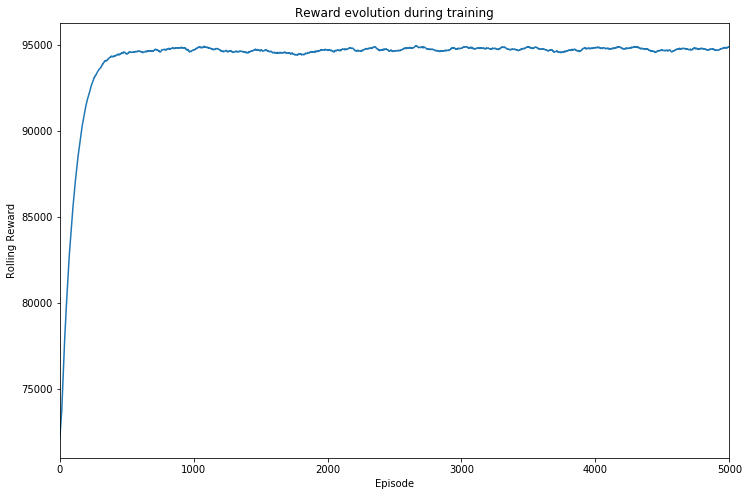

In [86]:
plt.figure(figsize=(12,8))
plt.title('Reward evolution during training')
plt.xlabel('Episode')
plt.ylabel('Rolling Reward')
plt.plot(rolling_rewards_hist)
plt.xlim((0, 5000))

In [87]:
_, inventory_hist = eval_agent(agent, sim, dt)

Text(0.5, 0, 'day')

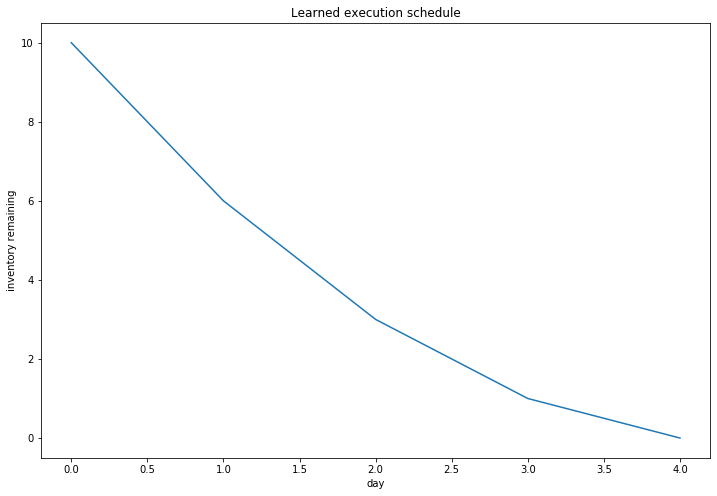

In [88]:
plt.figure(figsize=(12,8))

plt.title('Learned execution schedule')
plt.plot(inventory_hist)
plt.ylabel('inventory remaining')
plt.xlabel('day')


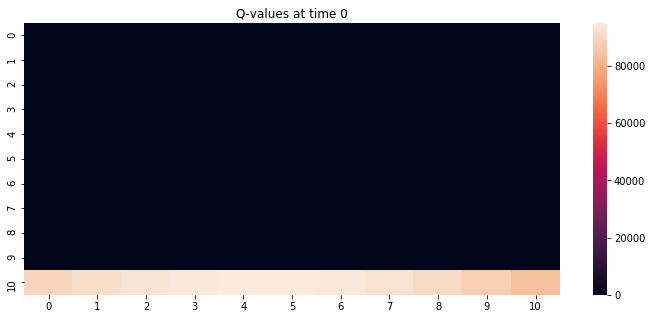

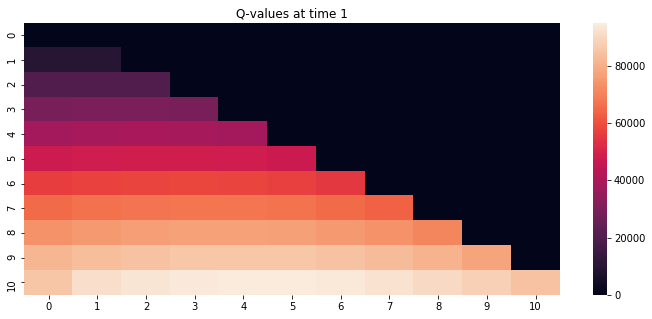

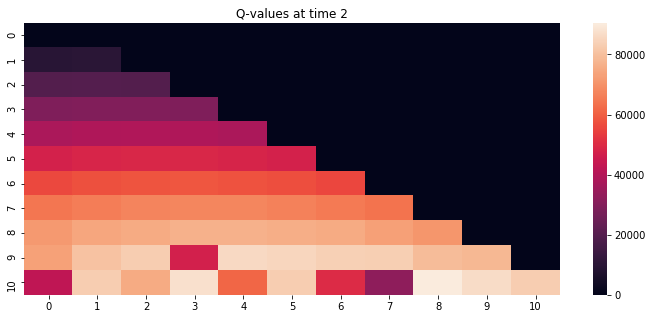

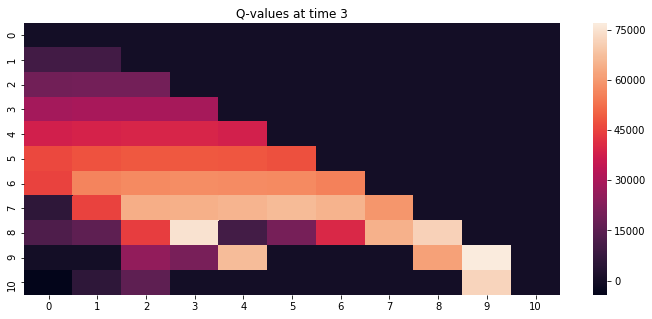

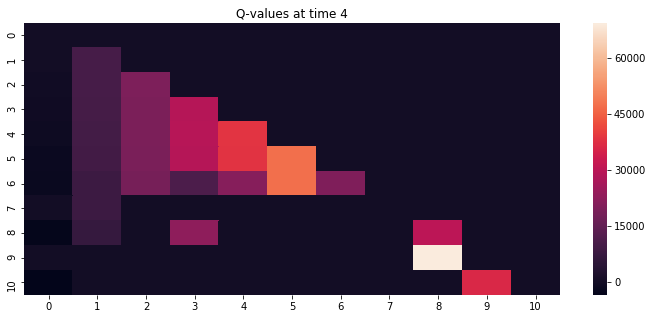

In [90]:
for i in range(horizon):
    plt.figure(figsize=(12,5))
    plt.title('Q-values at time {}'.format(i))
    plt.xlabel('Number of blocks sold')
    plt.ylabel('Inventory remaining')
    sns.heatmap(agent.Q_values[i],)
    plt.show()